# infos

    A Insurance All fez uma pesquisa com cerca de 380 mil clientes sobre o interesse em aderir a um novo produto de seguro de automóveis, no ano passado. Todos os clientes demonstraram interesse ou não em adquirir o seguro de automóvel e essas respostas ficaram salvas em um banco de dados junto com outros atributos dos clientes.

    O time de produtos selecionou 127 mil novos clientes que não responderam a pesquisa para participar de uma campanha, no qual receberão a oferta do novo produto de seguro de automóveis. A oferta será feita pelo time de vendas através de ligações telefônicas.

    Contudo, o time de vendas tem uma capacidade de realizar 20 mil ligações dentro do período da campanha.
    
   =============================================================================================
   
    Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

    Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

    E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

    Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

   =======================================================================================
    
    Explore os Dados usando ferramentas e testes Estatísticos com o objetivo de encontrar inconsistências dos dados e tratar possíveis dados faltantes.

    Levante Hipóteses sobre as características de transações legítimas e fraudulentas. Valide ou refute essas hipóteses através dos dados.

    Prepare os Dados para que os Algoritmos Estatísticos ou de Machine Learning sejam capazes de aprender a tarefa.

    Escreva vários algoritmos Classificadores.

    Contabilize a Performance do Modelo de Machine Learning e transforme em Performance de Negócio.

    Desenvolva uma API que retorne um “Score de Propensão” de compra para cada cliente, ou seja, uma probabilidade do cliente estar interessado em comprar um seguro de automóvel.

    Crie um README sobre como interpretar e usar a sua solução.

    Escreva um Relatório, respondendo às perguntas de negócio.

In [2]:
# terminal é bom devido aos comandos de inserção de dados *****************************

# dbeaver é bom para validar queries do/no jupyter notebook ou pegar informações rápidas sem precisar processar dados ******************


######################conexão específica para postgres no terminal

# instalar psql terminal ubuntu
# man psql = comando para abrir o manual do psql (ou main)
# psql -h comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com \   o \ é pra continuar da próxima linha
# > -p 5432 \           # testar sem todos os escapes
# > -d comunidadedsdb \
# > -U member \
# > -W cdspa

# agora dentro do database, encontrar schemas/tabelas

# \dn listar os schemas
# \dt pa004.*             comando p/ ver tabelas, como n se sabe as tabelas na primeira vez, passar o * q é um coringa
# \dt+ pa004.*            saber o tamanho das tabelas em mbs
# select * from pa004.users limit 10;
# \q sai do banco de dados



##################### comandos no dbeaver(linguagem sql)
# select nspname from pg_catalog.pg_namespace pn          para ver os schemas
# select tablename from pg_catalog.pg_tables where schemaname = 'pa004'           para ver as tabelas


#################### pelo python usar o sql alchemy/pandas  (psycopg2 específico para postgres)
# geralmente usar pandas , possue métodos de conexão com bancos

# não deixar as credenciais no jupyter notebook/não comitar as credenciais ***********************
# usar máscara pra esconder as credenciais

# sempre fechar o cursor (cursor.close()) e a conexão (conn.close()) **************************

# import psycopg2 as pg


# conn = pg.connect(user= password= gost= port= database=)
# query_table_users = ***
#     SELECT * FROM pa004.users...
#     LIMIT 10;
#     ****
# (primeiro criar a conexão e a query_tables_users)
# df=pd.read_sql(query_tables_users,conn)
# df.head()

# 0 **Imports**

In [2]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import scikitplot as skplt
import matplotlib.gridspec as gridspec
import warnings;   warnings.filterwarnings("ignore")
import xgboost as xgb
import lightgbm as lightgbm

from matplotlib            import pyplot  as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from pylab                 import rcParams
from IPython.display       import Image
from scipy                 import stats  as ss
from sklearn               import model_selection as ms
from sklearn.metrics       import accuracy_score, f1_score,classification_report
from sklearn               import preprocessing as pp
from sklearn               import ensemble        as en
from sklearn               import linear_model    as lm
from sklearn               import neighbors       as nh
from sklearn.metrics import top_k_accuracy_score
from sklearn.tree          import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# pd.options.display.float_format = '{:,.2f}'.format

##  **0.1 Helper functions**

In [3]:
# def jupyter_settings():
#     %matplotlib inline
#     %pylab inline
    
#     plt.style.use( 'bmh' )
#     plt.rcParams['figure.figsize'] = [25, 12]
#     plt.rcParams['font.size'] = 24
#     sns.set_style("whitegrid")
#     plt.style.use("dark_background")
#     rcParams['figure.figsize'] = 28,10
        
#     pd.options.display.max_columns = None
#     pd.options.display.max_rows = None
#     pd.set_option( 'display.expand_frame_repr', False )
#     pd.options.display.float_format = '{:,.2f}'.format
    
#     sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def precision_at_k( data, k=10 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

def recall_at_k( data, k=15 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )

In [4]:
# jupyter_settings()

## **0.2 Loading data**

In [5]:
test=pd.read_csv('../data/test.csv')

df_insurance_raw=pd.read_csv('../data/insurance_202206101822.csv')
df_users_raw=pd.read_csv('../data/users_202206101824.csv')
df_vehicles_raw=pd.read_csv('../data/vehicle_202206101824.csv')

# merge
df_raw=pd.merge(df_insurance_raw,df_users_raw,how='left',on='id')
df_raw=pd.merge(df_raw,df_vehicles_raw,how='left',on='id')

# **Step 1 Data description**

In [7]:
df1=df_raw.copy()

In [28]:
df1

,id,previously_insured,annual_premium,vintage,response,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
0,1,0,40454.0,217,1,Male,44,28.0,26.0,1,> 2 Years,Yes
1,2,0,33536.0,183,0,Male,76,3.0,26.0,1,1-2 Year,No
2,3,0,38294.0,27,1,Male,47,28.0,26.0,1,> 2 Years,Yes
3,4,1,28619.0,203,0,Male,21,11.0,152.0,1,< 1 Year,No
4,5,1,27496.0,39,0,Female,29,41.0,152.0,1,< 1 Year,No
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,30170.0,88,0,Male,74,26.0,26.0,1,1-2 Year,No
381105,381106,1,40016.0,131,0,Male,30,37.0,152.0,1,< 1 Year,No
381106,381107,1,35118.0,161,0,Male,21,30.0,160.0,1,< 1 Year,No
381107,381108,0,44617.0,74,0,Female,68,14.0,124.0,1,> 2 Years,Yes


## **1.1 Data types**

In [18]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## **1.2 Change types**

In [19]:
df1['region_code']=df1['region_code'].astype('int64')
df1['policy_sales_channel']=df1['policy_sales_channel'].astype('int64')

## **1.3 Check NA**

In [20]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
response                0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## **1.4 Descriptive statistics**

In [21]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

### **1.4.1 Numerical attributes**

In [22]:
# Central Tendency - mean, median 
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(min)).T
d3=pd.DataFrame(num_attributes.apply(max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min () )).T
d5=pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6=pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
2,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
3,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
4,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788
5,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
6,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
7,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
8,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302


### **1.4.2 Categorical attributes**

In [23]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

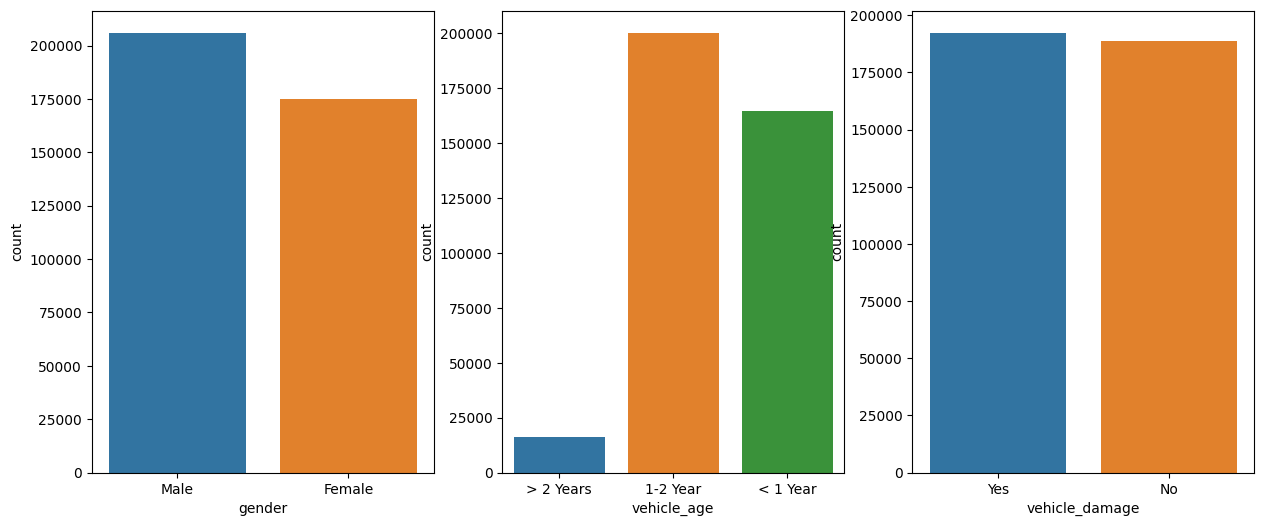

In [24]:
rcParams['figure.figsize'] = 15,6

plt.subplot(1,3,1);
sns.countplot(x='gender',data=df1);

plt.subplot(1,3,2);
sns.countplot(x='vehicle_age',data=df1);

plt.subplot(1,3,3);
sns.countplot(x='vehicle_damage',data=df1);

# **Step 2 Feature Engineering**

In [25]:
df2=df1.copy()

In [26]:
# vehicle age
df2['vehicle_age']=df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' 
                                            else 'between_1_2_years' if x == '1-2 Year'
                                            else 'below_1_year')

# vehicle damage
# df2['vehicle_damage']=df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

df2['previously_insured']=df2['previously_insured'].apply(lambda x: 'Yes' if x == 1 else 'No')

df2['driving_license']=df2['driving_license'].apply(lambda x: 'Yes' if x == 1 else 'No')

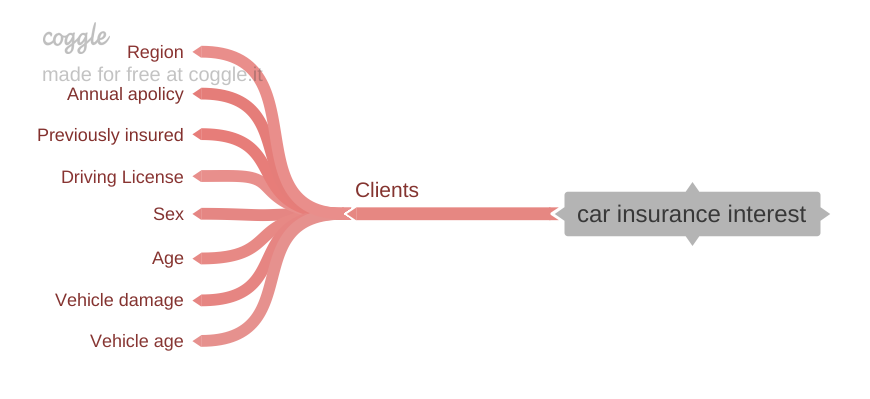

In [27]:
Image('../img/car_insurance_interest.png')

## **2.1 Hypothesis creation**

### **2.1.2 Clients**

**1** Quanto maior a apólice de saúde, maior a chance do interesse

**2** Se não tem seguro automotivo, maior chance de interesse

**3** Se tem carteira de motorista, maior chance de interesse

**4** Homens têm maior chance de se interessar

**5** Pessoas mais velhas têm mais chance de se interessar

**6** Proprietários de veículos mais novos têm maior chance de se interessar

**7** Pessoas que moram em regiões com mais acidentes e menos seguras têm mais chance de se interessar

**8** Pessoas há mais tempo associadas têm mais chance de se interessar

### **2.2 Feature engineering**

# **Step 3 Variable filtering**

In [28]:
df3=df2.copy()

## **3.1 Row filtering**

## **3.2 Column filtering**

# **Step 4 Exploratory data analysis**

In [30]:
df4=df3.copy()

## **4.1 Univariate analysis**

### **4.1.1 Response variable**

response
0    334399
1     46710
Name: count, dtype: int64

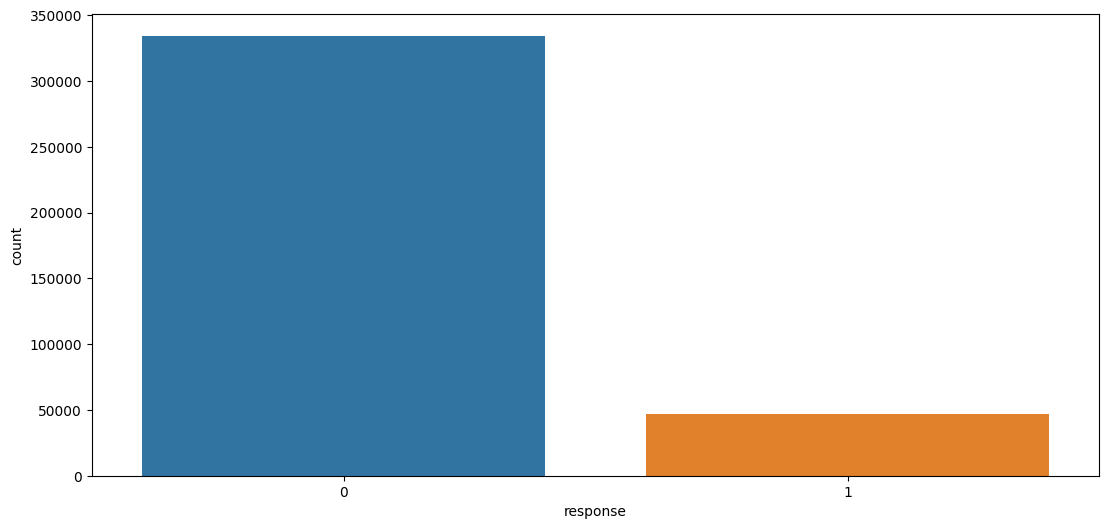

In [31]:
rcParams['figure.figsize'] = 13,6

sns.countplot(x='response',data=df4);
df4['response'].value_counts()

### **4.1.2 Numerical variables**

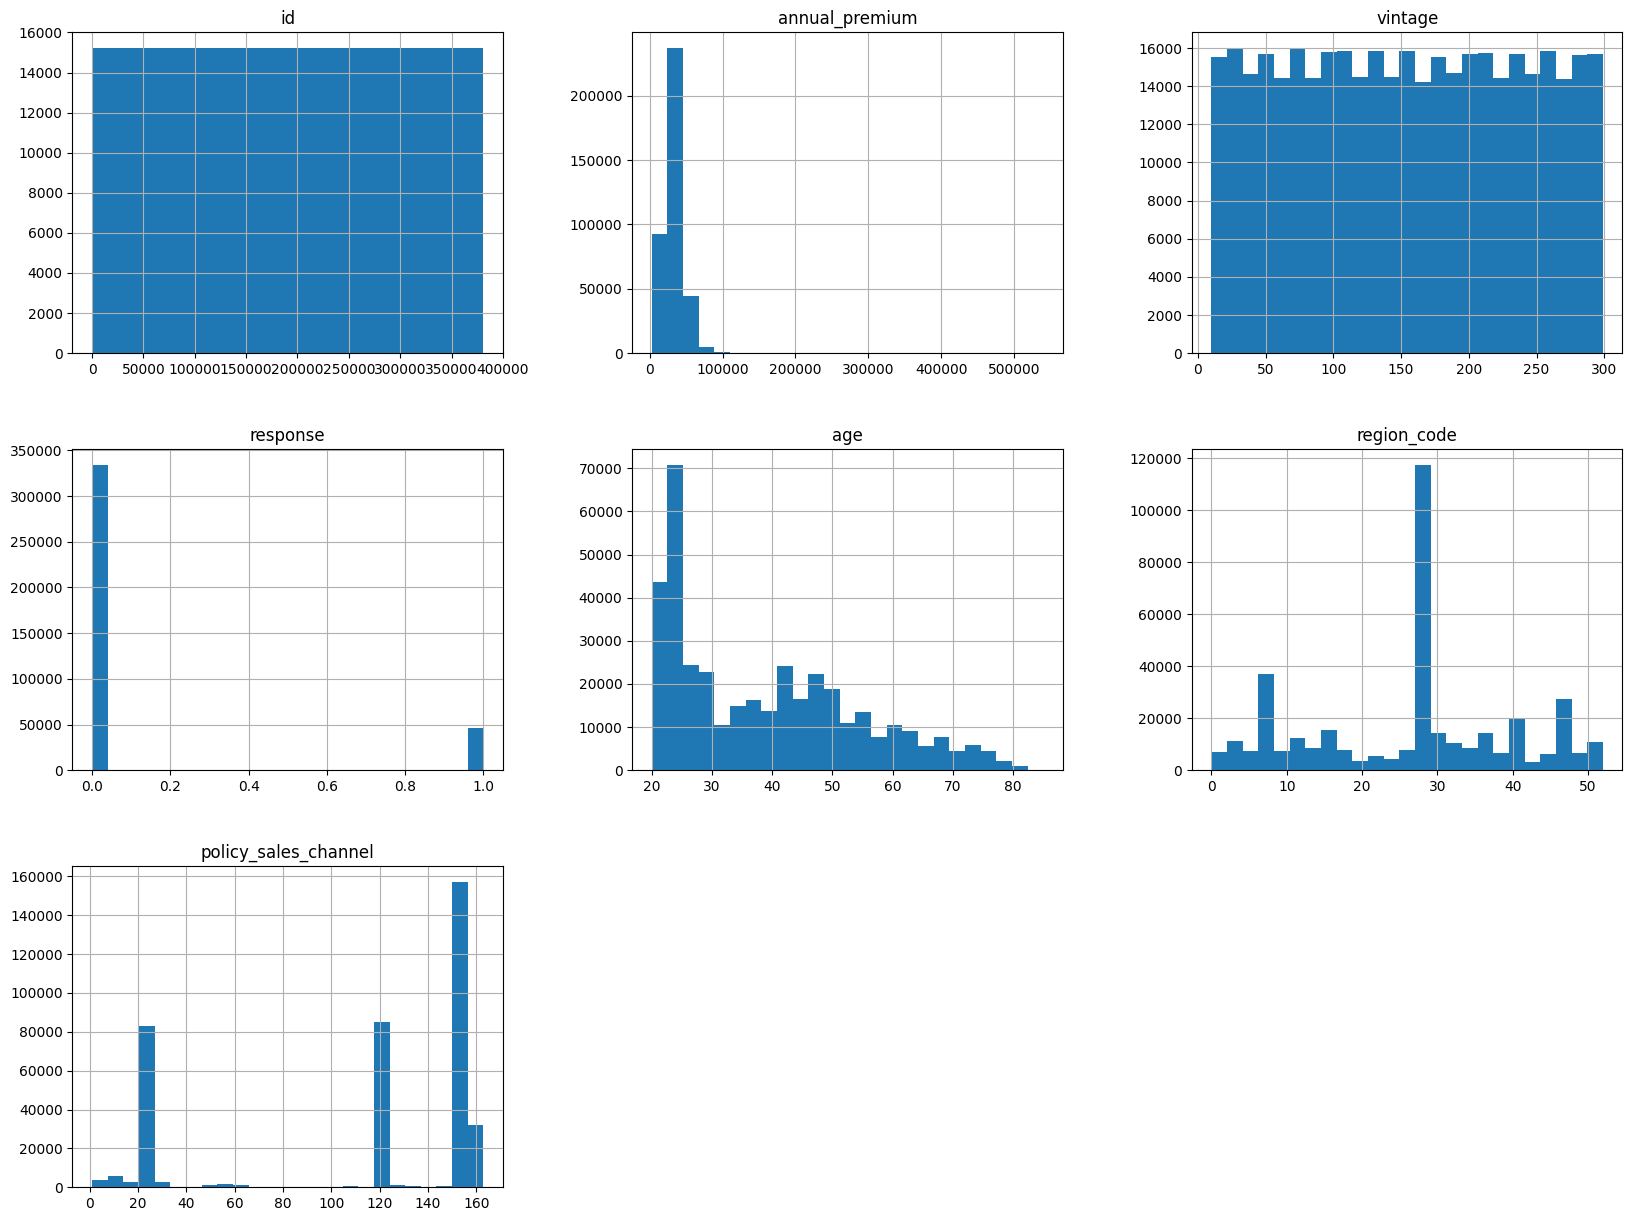

In [32]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
cat_attributes = df4.select_dtypes(exclude=['int64','float64'])

rcParams['figure.figsize'] = 20,15
num_attributes.hist(bins=25);

### **4.1.3 Categorical variables**

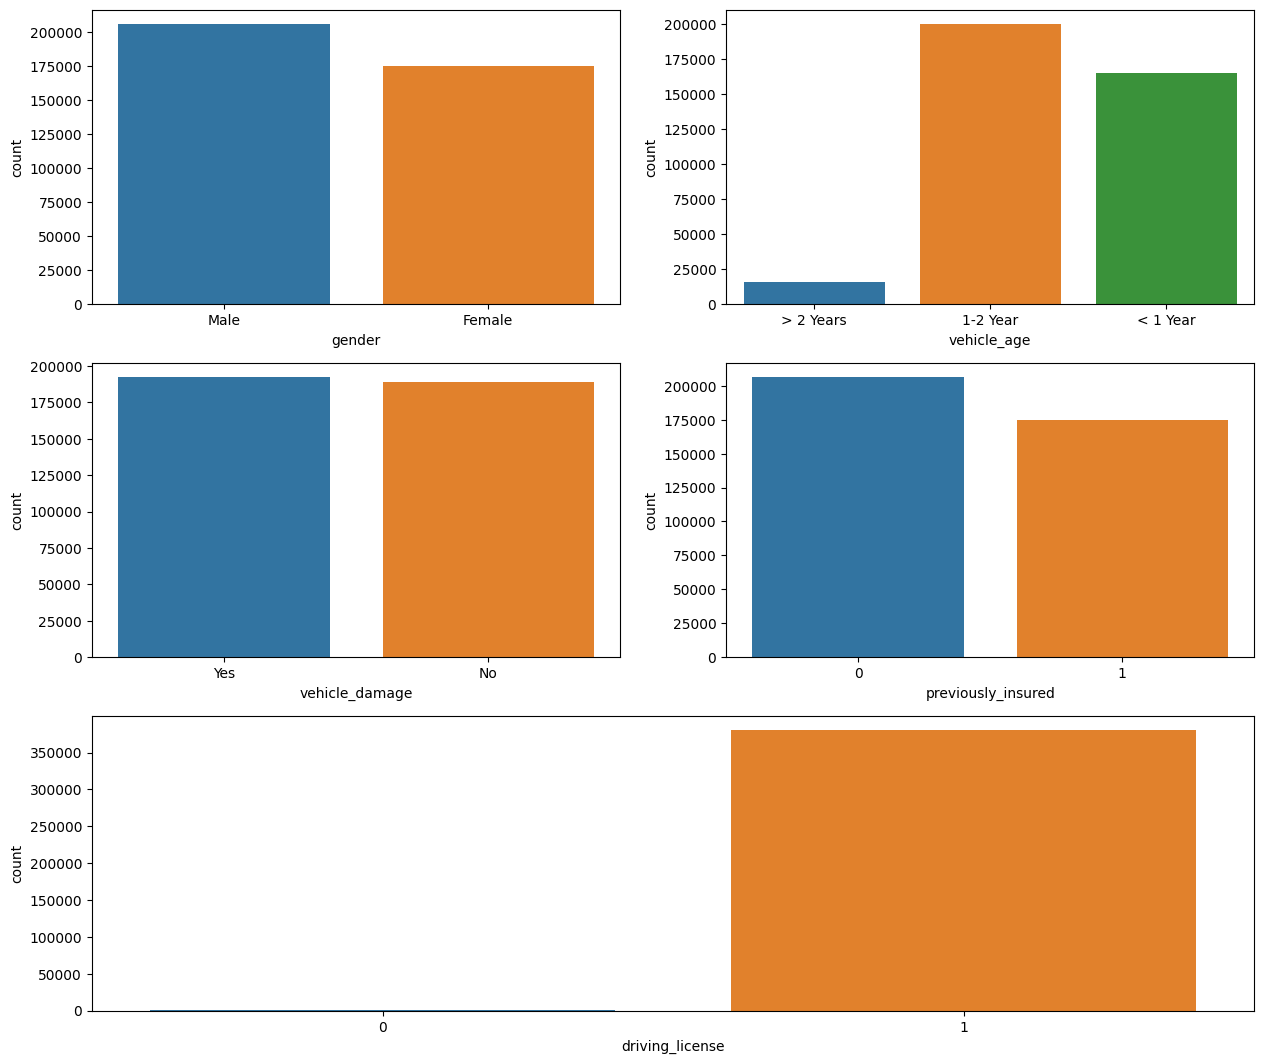

In [33]:
rcParams['figure.figsize'] = 15,13

grid=gridspec.GridSpec(3,2)

plt.subplot(grid[0,0])
# plt.subplot(1,3,1);
sns.countplot(x='gender',data=df1);

plt.subplot(grid[0,1])
# plt.subplot(1,3,2);
sns.countplot(x='vehicle_age',data=df1);

plt.subplot(grid[1,0])
# plt.subplot(1,3,3);
sns.countplot(x='vehicle_damage',data=df1);

plt.subplot(grid[1,1])
# plt.subplot(1,3,2);
sns.countplot(x='previously_insured',data=df1);

plt.subplot(grid[2,:])
# plt.subplot(1,3,3);
sns.countplot(x='driving_license',data=df1);

## **4.2 Bivariate analysis**


### **4.2.1 Annual_premium**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


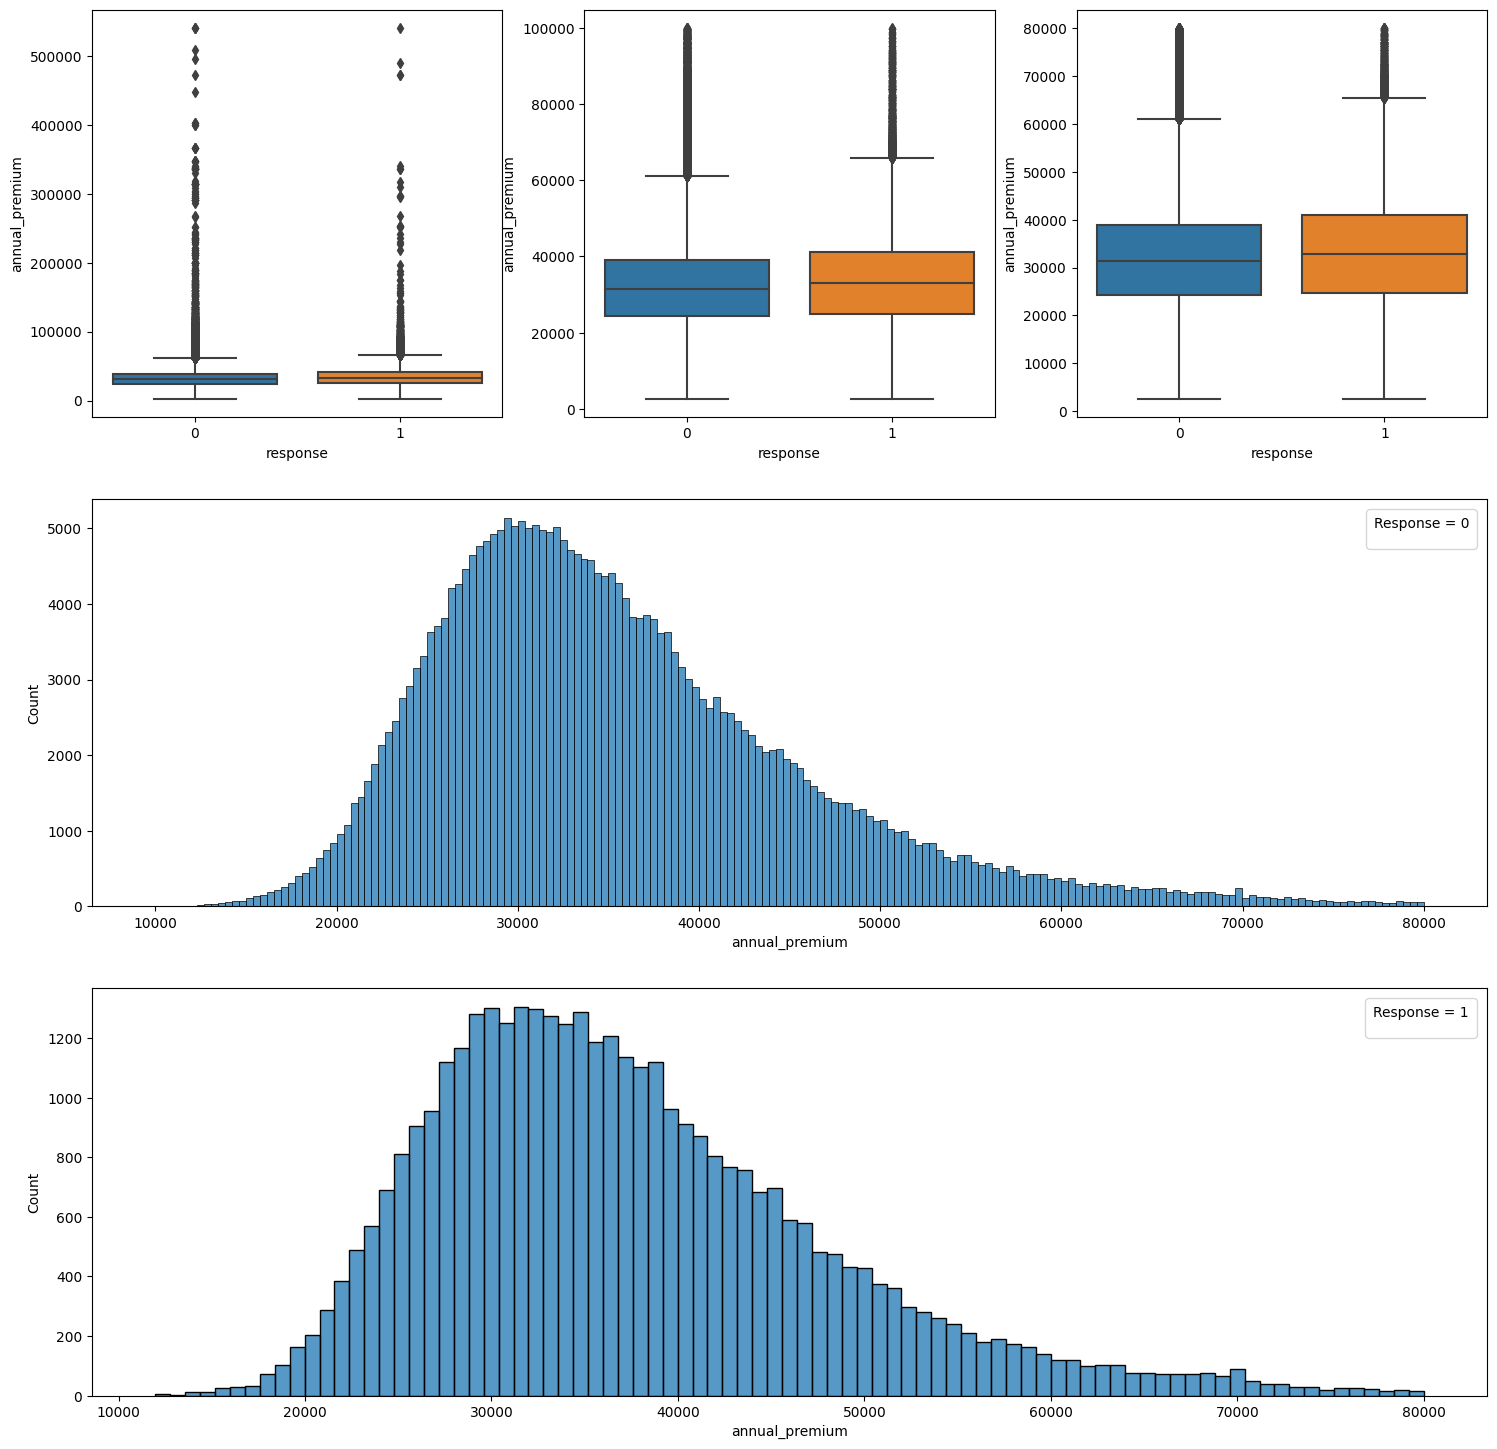

In [34]:
rcParams['figure.figsize'] = 18,18
grid=gridspec.GridSpec(3,3)


plt.subplot(grid[0,0])
sns.boxplot(x='response',y='annual_premium',data=df4); 

aux4=df4[df4['annual_premium'] < 100000]
plt.subplot(grid[0,1])
sns.boxplot(x='response',y='annual_premium',data=aux4);


aux4=df4[df4['annual_premium'] < 80000]
plt.subplot(grid[0,2])
sns.boxplot(x='response',y='annual_premium',data=aux4);


aux=df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00=aux.loc[df4['response']==0,'annual_premium']     
plt.subplot(grid[1,:])

plt.legend(title='Response = 0', fontsize="x-large")
sns.histplot(aux00);

aux00=aux.loc[df4['response']==1,'annual_premium'] 
plt.subplot(grid[2,:])
plt.legend(title='Response = 1', fontsize="x-large")
sns.histplot(aux00);

### **4.2.2 Vintage**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


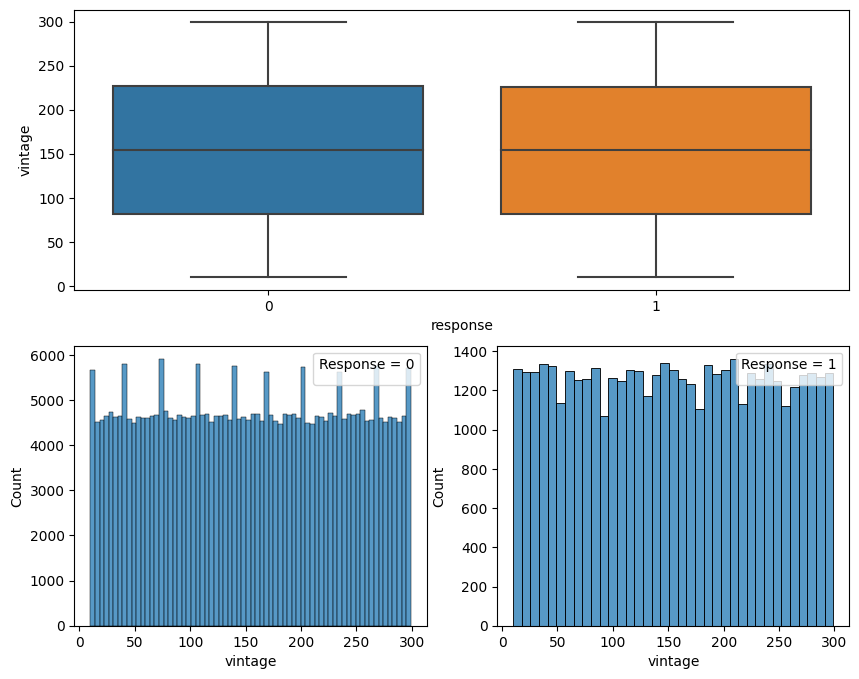

In [35]:
rcParams['figure.figsize'] = 10,8

grid=gridspec.GridSpec(2,2)

plt.subplot(grid[0,:])
sns.boxplot(x='response',y='vintage',data=df4);

plt.subplot(grid[1,0])
plt.legend(title='Response = 0')
sns.histplot(df4.loc[df4['response']==0,'vintage']);

plt.subplot(grid[1,1])
plt.legend(title='Response = 1')
sns.histplot(df4.loc[df4['response']==1,'vintage']);

### **4.2.3 Age**

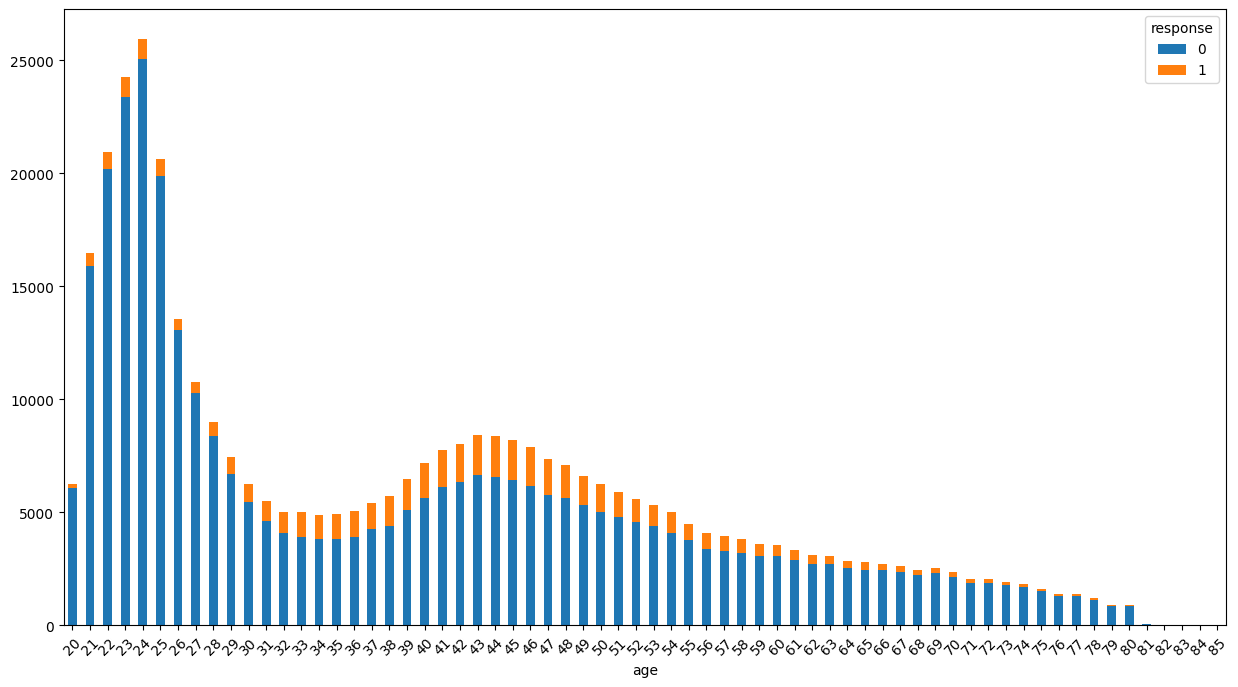

In [36]:
rcParams['figure.figsize'] = 15,8

# aux=df4[['id','age','response']].groupby(['age','response']).count().reset_index()
# sns.scatterplot(x='age',y='id',hue='response',data=aux);

crosstb=pd.crosstab(df4['age'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)
plt.xticks(rotation=45);

### **4.2.4 Region_code**

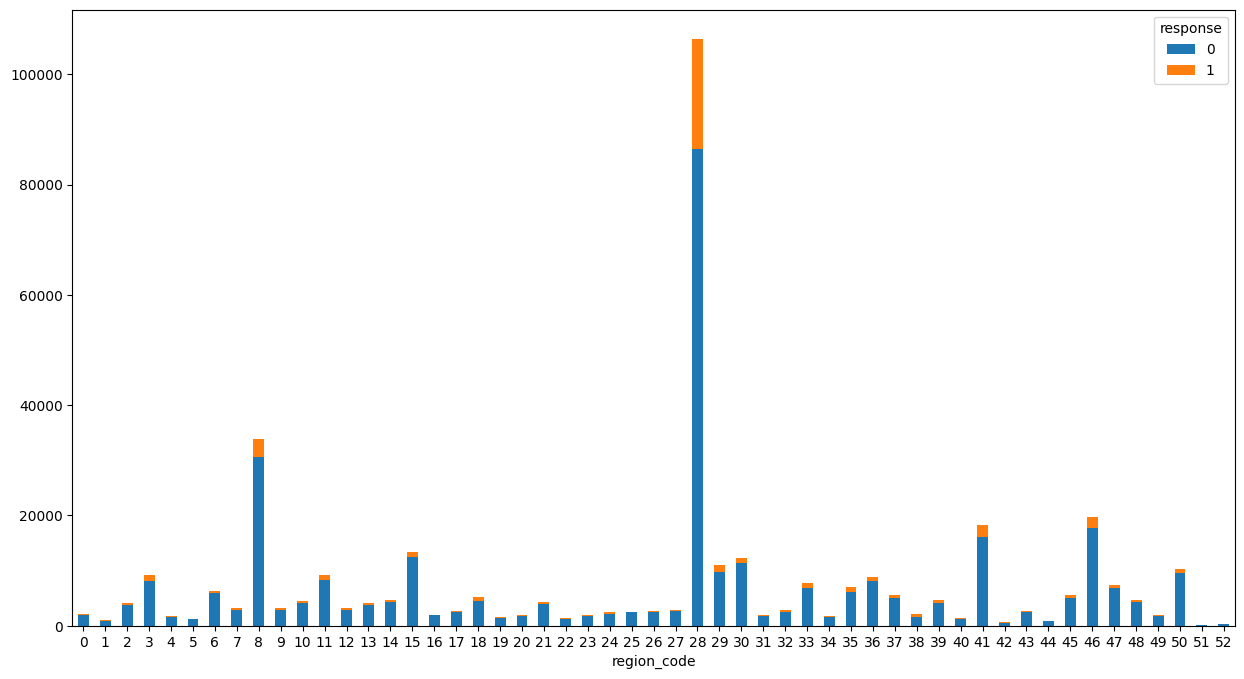

In [37]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['region_code'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [38]:
# rcParams['figure.figsize'] = 15,15

# grid=gridspec.GridSpec(2,2)

# plt.subplot(grid[0,:])
# aux0=df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
# sns.scatterplot(x='region_code',y='id',hue='response',data=aux0);

# # plt.subplot(grid[1,:])
# # sns.boxplot(x='response',y='region_code',data=df4);   # olhar a mediana/quartis/medianas de cada um dos grupos em relação a idade
# # 0 = 35 anos mediana, 1° ao 3° quartil : 25 a 50 anos


# plt.subplot(grid[1,0])
# aux00=df4.loc[df4['response']==0,'region_code']        # loc para passar a coluna como string
# plt.legend(title='Response = 0')
# sns.histplot(aux00);


# plt.subplot(grid[1,1])
# aux00=df4.loc[df4['response']==1,'region_code']        
# plt.legend(title='Response = 1')
# sns.histplot(aux00);

### **4.2.5 Policy_sales_channel**

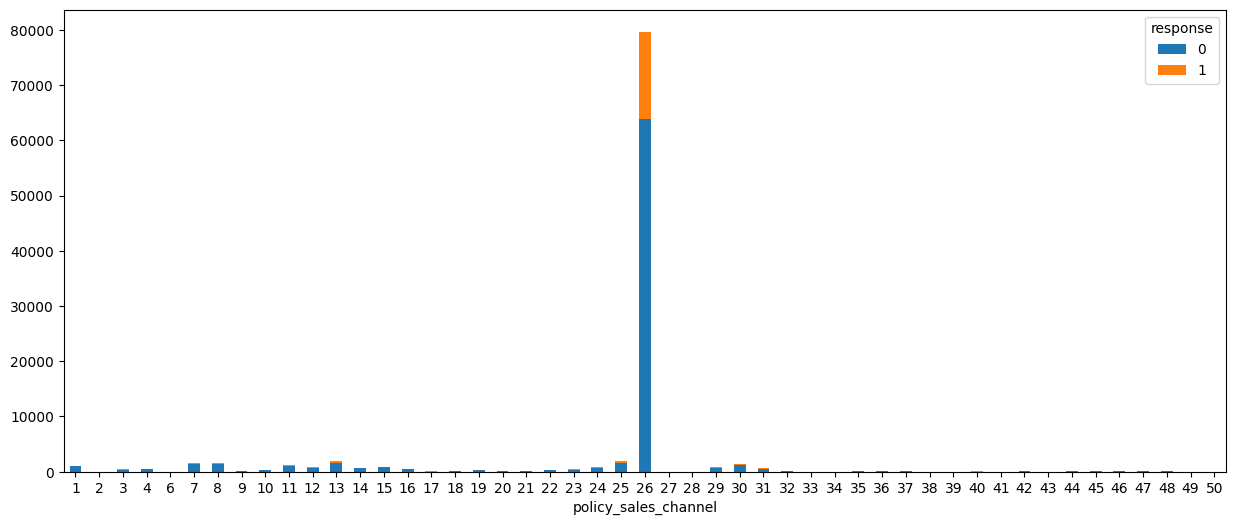

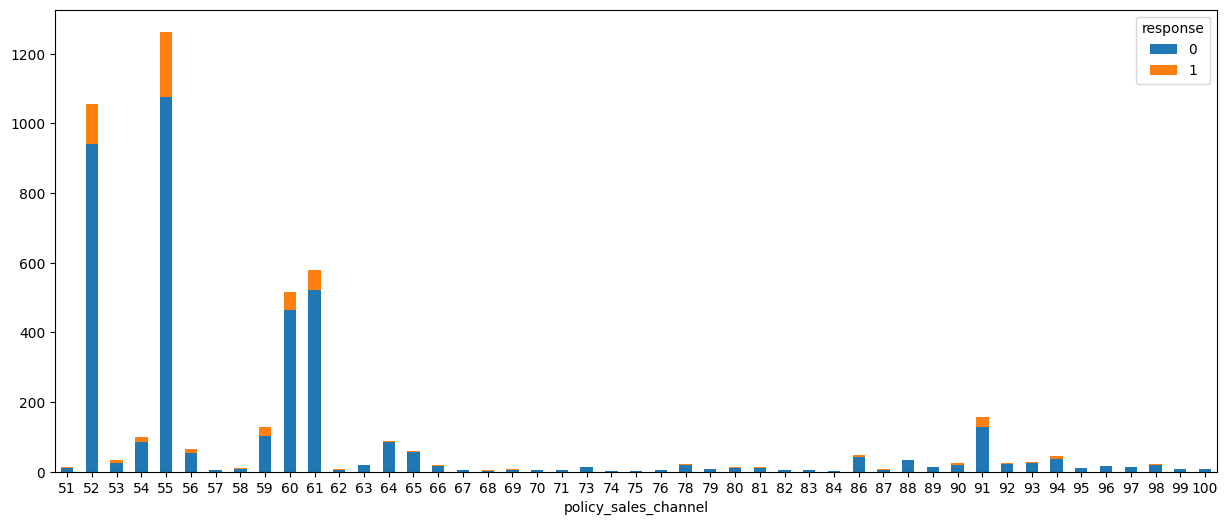

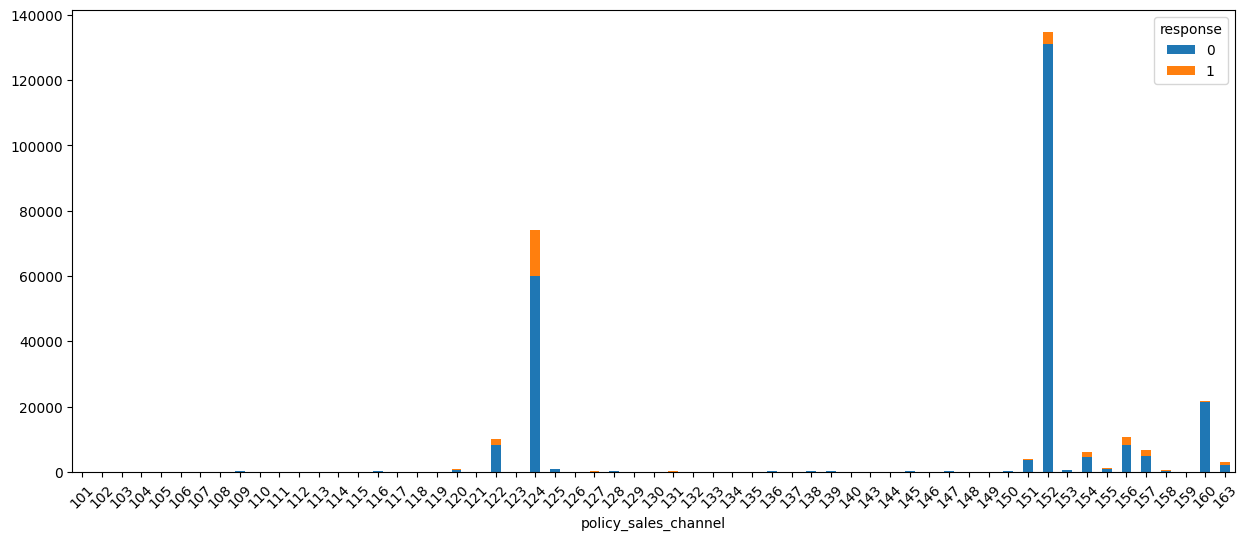

In [39]:
rcParams['figure.figsize'] = 15,6

aux=df4[df4['policy_sales_channel']<=50]
crosstb=pd.crosstab(aux['policy_sales_channel'],aux['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

aux1=df4[(df4['policy_sales_channel']>50) & (df4['policy_sales_channel']<=100)]
crosstb1=pd.crosstab(aux1['policy_sales_channel'],aux1['response'])
pl = crosstb1.plot(kind="bar", stacked=True, rot=0)


aux2=df4[df4['policy_sales_channel']>100]
crosstb2=pd.crosstab(aux2['policy_sales_channel'],aux2['response'])
pl = crosstb2.plot(kind="bar", stacked=True, rot=0)
plt.xticks(rotation=45);

In [40]:
# rcParams['figure.figsize'] = 15,8

# aux=df4[['policy_sales_channel','response']].groupby(['policy_sales_channel']).sum().reset_index()
# sns.barplot(x='response',y='policy_sales_channel',data=aux);
# plt.xticks(rotation=45);

# fazer o stacked percentage plot

### **4.2.6 Vehicle_age**

In [41]:
df4[['vehicle_age','response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,proportion
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


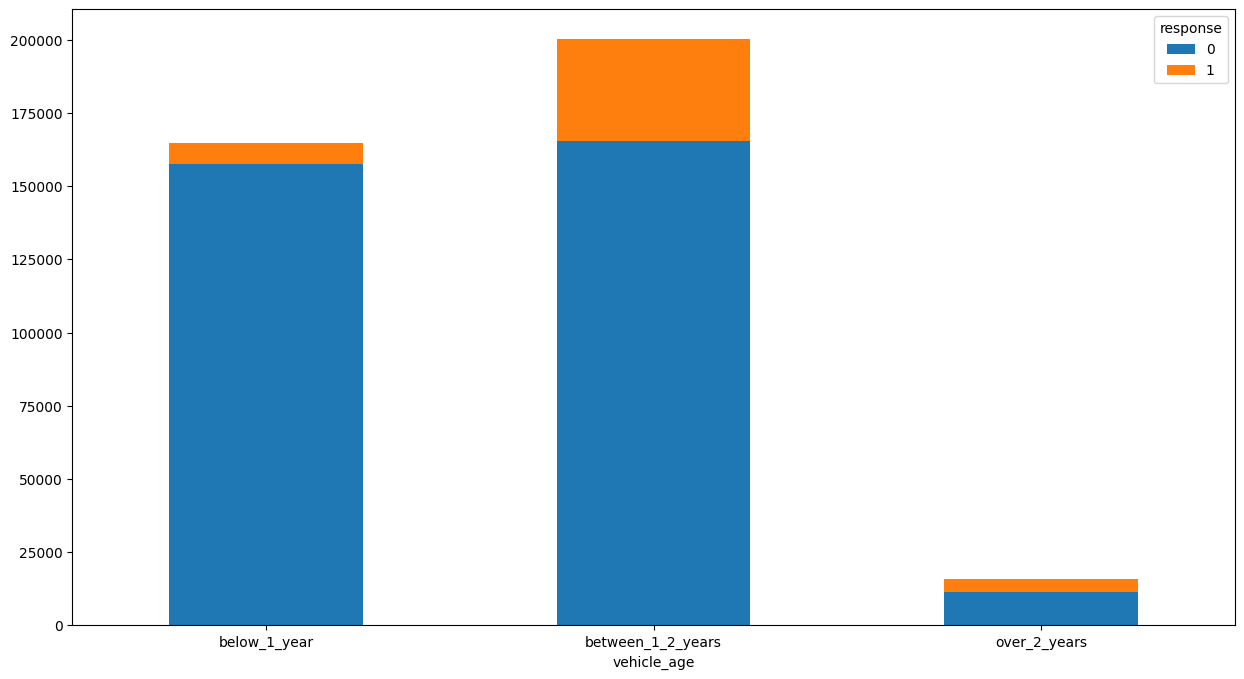

In [42]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['vehicle_age'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

### **4.2.7 Vehicle_damage**

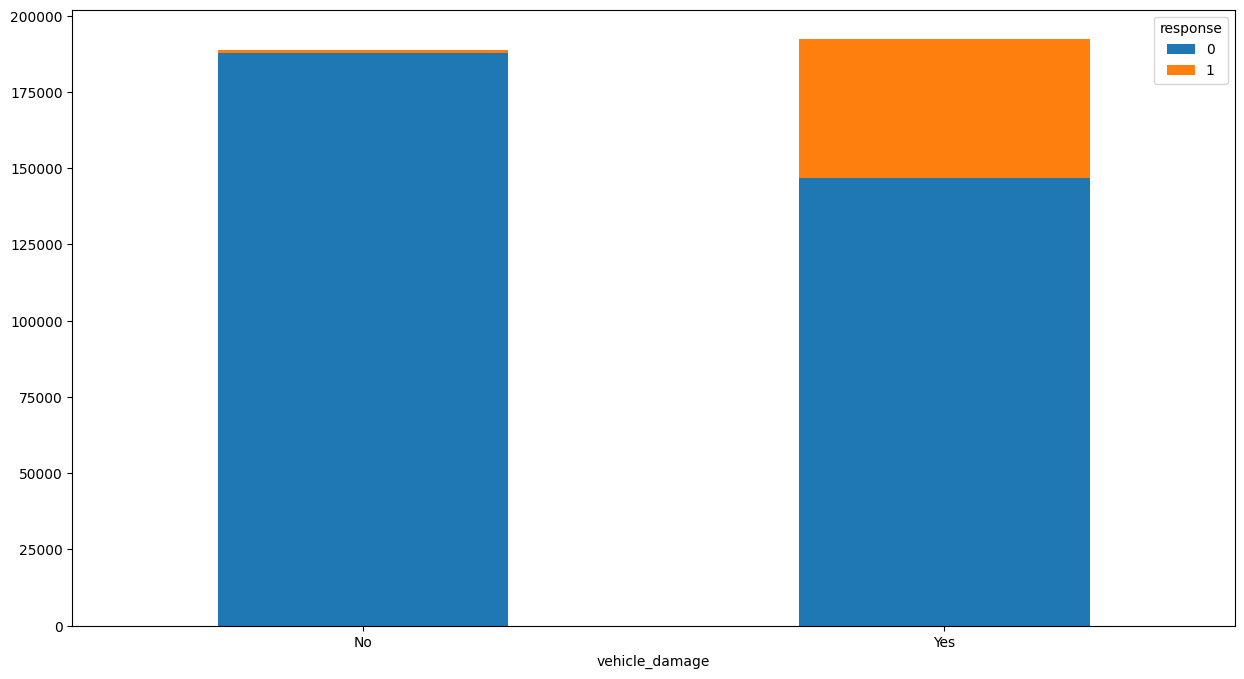

In [43]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['vehicle_damage'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

### **4.2.8 Previously_insured**

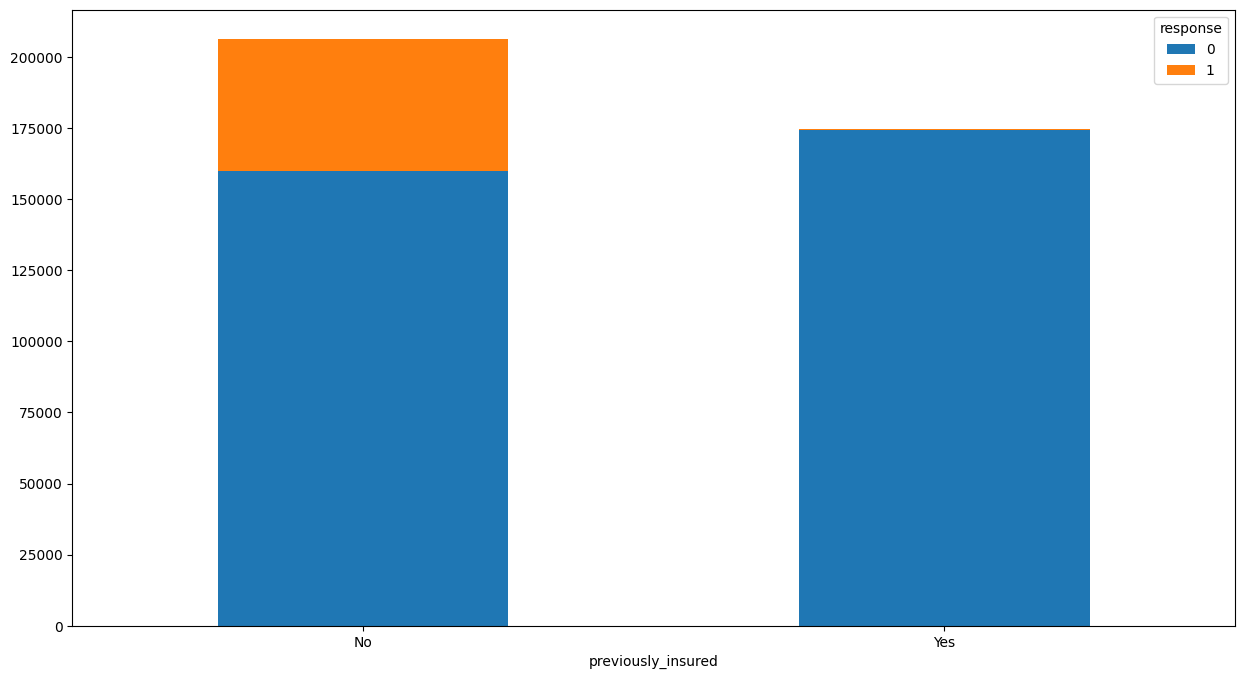

In [44]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['previously_insured'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [45]:
# pode ser um 'vazamento de dados' , pq é muito relacionado com a variável resposta (100% das pessoas q já tem, não querem), é como se fosse um if/else para o modelo

# pd.crosstab(df4['previously_insured'],df4['response']),'\n'

pd.crosstab(df4['previously_insured'],df4['response']).apply(lambda x: x /x.sum(), axis=1)

response,0,1
previously_insured,,
No,0.774546,0.225454
Yes,0.999095,0.000905


### **4.2.9 Driving_license**

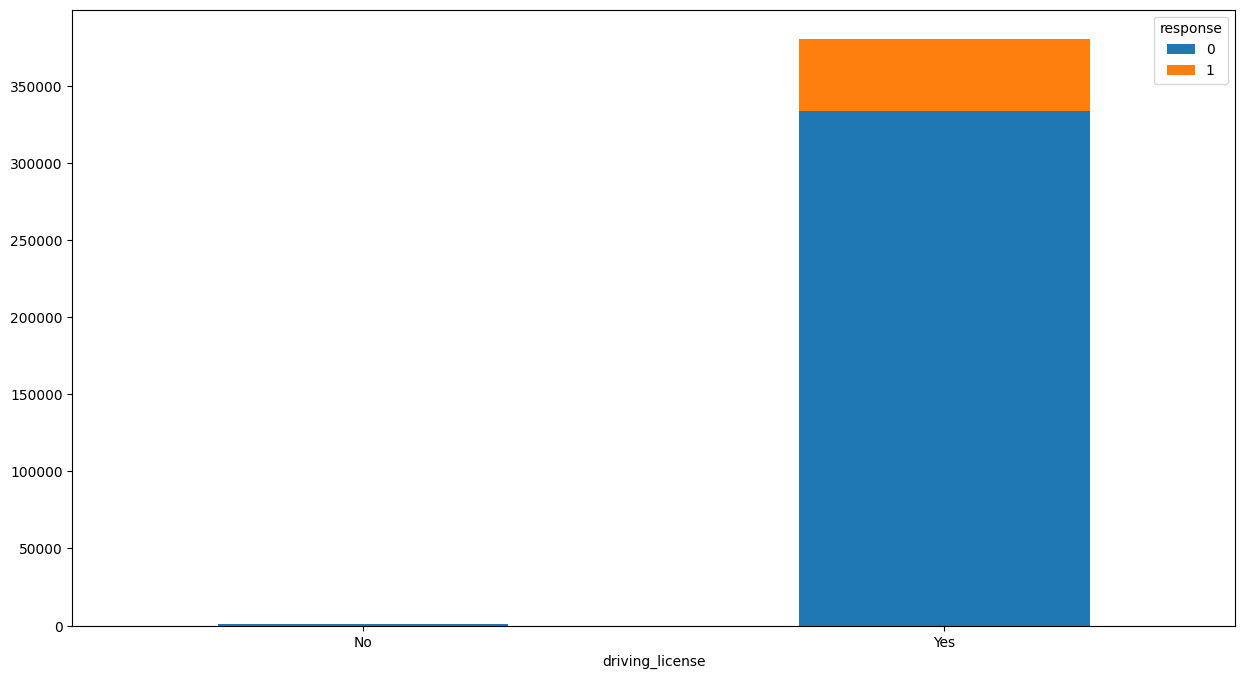

In [46]:
rcParams['figure.figsize'] = 15,8

crosstb=pd.crosstab(df4['driving_license'],df4['response'])
pl = crosstb.plot(kind="bar", stacked=True, rot=0)

In [47]:
pd.crosstab(df4['driving_license'],df4['response']).apply(lambda x: x /x.sum(), axis=1)

response,0,1
driving_license,,
No,0.949507,0.050493
Yes,0.877283,0.122717


In [48]:
# plt.subplot(1,2,1)
# sns.countplot(df4['driving_license'])
# plt.subplot(2,2,2)
# aux1 = df4[['driving_license', 'response']].groupby( 'driving_license' ).sum().sort_values('response',ascending=False).reset_index()
# sns.barplot( x='driving_license', y='response', data=aux1 );

In [49]:
# soma agregada
# aux=df4[['driving_license','response']].groupby('response').sum().reset_index()
# # sns.barplot(x='response',y='driving_license',data=aux);

# aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
# aux

# 87% das pessoas que dirigem não querem o seguro = a variável é discriminativa porém precisa de outra junto

In [59]:
# print(pd.crosstab(df4['driving_license'],df4['response']),'\n')
# print(pd.crosstab(df4['driving_license'],df4['response']).apply(lambda x: x /x.sum(), axis=1))

## **hypos**

**1** Quanto maior a apólice de saúde, maior a chance do interesse

**2** Se não tem seguro automotivo, maior chance de interesse

**3** Homens têm maior chance de se interessar

**4** Pessoas mais velhas têm mais chance de se interessar

**5** Proprietários de veículos mais novos têm maior chance de se interessar

**6** Pessoas que moram em regiões com mais acidentes e menos seguras têm mais chance de se interessar

**7** Pessoas há mais tempo associadas têm mais chance de se interessar

### **H1 Quanto maior a apólice de saúde, maior a chance do interesse**

    falso

In [60]:
# print(df4['annual_premium'].value_counts().head(5))
# aux1=df4[['annual_premium','response']].groupby('annual_premium').sum().sort_values('response',ascending=False).reset_index()
# print(aux1.head())

In [61]:
# plt.subplot(1,2,1)
# sns.boxplot(x='response',y='annual_premium',data=df4);

# plt.subplot(1,2,2)
# x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

### **H2 Se não tem seguro automotivo, maior chance de interesse**

    verdadeiro

In [62]:
# aux2 = df4[['previously_insured', 'response']].groupby( 'previously_insured' ).sum().reset_index()
# aux2

In [63]:
# plt.subplot( 1, 3, 1 )
# aux2.hist(bins=25);
# # df4['previously_insured'].hist(bins=25);

# plt.subplot( 1, 3, 1 )
# df4['previously_insured'].hist(bins=25);

# plt.subplot( 1, 3, 2 )
# sns.barplot( x='previously_insured', y='response', data=aux2 );

# plt.subplot( 1, 3, 3 )
# x = sns.heatmap( aux2.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

### **H3 Homens têm maior chance de se interessar**

    verdadeiro

In [64]:
# aux3 = df4[['gender', 'response']].groupby( 'gender' ).sum().reset_index()
# aux3

In [65]:
# plt.subplot( 1, 2, 1 )
# df4['gender'].hist(bins=25);


# plt.subplot( 1, 2, 2 )
# sns.barplot( x='gender', y='response', data=aux3 );


# plt.subplot( 1, 3, 3 )
# x = sns.heatmap( aux3.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

### **H4 Pessoas mais velhas têm mais chance de se interessar**


    verdadeiro

In [66]:
# df4['age'].value_counts().head(20)
# aux4=df4[['age','response']].groupby('age').sum().sort_values('response',ascending=False).reset_index()
# aux4.head()

In [67]:
# plt.subplot( 1, 2, 1 )
# df4['age'].hist(bins=25);


# plt.subplot( 1, 2, 2 )
# sns.barplot( x='age', y='response', data=aux4 );
# plt.xticks( rotation=5 )


# plt.figure()
# x = sns.heatmap( aux4.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

In [68]:
# sns.boxplot(x='response',y='age',data=df4)

### **H5 Proprietários de veículos mais novos têm maior chance de se interessar**

In [69]:
# df4['vehicle_age'].value_counts()
# aux5=df4[['response','vehicle_age']].groupby('vehicle_age').sum().reset_index()
# aux5

In [70]:
# fig, (ax1,ax2) = plt.subplots(1,2)
# labels = '1-2 year', '< 1 year', '> 2 years'
# sizes = [200316, 164786, 16007]
# ax1.pie(sizes, labels=labels, autopct='%1.1f%%',colors=colors);


# labels = '1-2 year', '< 1 year', '> 2 years'
# sizes = [34806, 7202, 4702]
# ax2.pie(sizes, labels=labels, autopct='%1.1f%%',colors=colors);


# plt.tight_layout()

### **H6 Pessoas que moram em regiões com mais acidentes e menos seguras têm mais chance de se interessar**

    falso

In [71]:
# df4['region_code'].value_counts().head(10)

In [72]:
# aux6=df4[['response','region_code']].groupby('region_code').sum().sort_values('response',ascending=False).reset_index()
# aux6.head(10)

In [73]:
# plt.subplot( 1, 2, 1 )
# df4['region_code'].hist(bins=25);

# plt.subplot( 1, 2, 2 )
# sns.barplot( x='region_code', y='response', data=aux6 );
# plt.xticks( rotation=5 );

# plt.figure()
# x = sns.heatmap( aux6.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

### **H7 Pessoas há mais tempo associadas têm mais chance de se interessar**

    falsa

In [74]:
# df4['vintage'].value_counts().head(10)

In [75]:
# aux7=df4[['response','vintage']].groupby('vintage').sum().sort_values('response',ascending=False).reset_index()
# aux7.head(10)

In [76]:
# sns.boxplot(x='response',y='vintage',data=df4);

In [77]:
# plt.subplot( 1, 3, 1 )
# df4['vintage'].hist(bins=25);

# plt.subplot( 1, 3, 2 )
# sns.barplot( x='vintage', y='response', data=aux7 );

# plt.subplot( 1, 3, 3 )
# x = sns.heatmap( aux7.corr( method='pearson' ), annot=True );
# bottom, top = x.get_ylim()
# x.set_ylim( bottom+0.5, top-0.5 );

### **4.2.1 Resumo das hipóteses**

## **4.3 Multivariate analysis**

### **4.3.1 Numerical attributes**

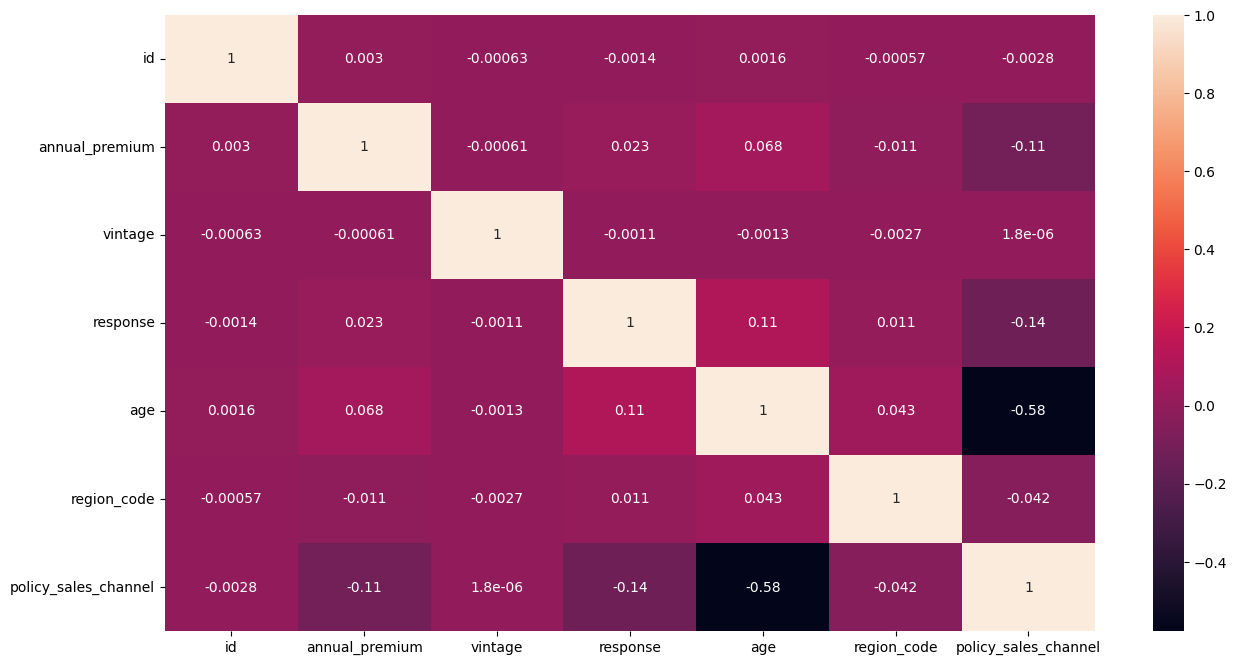

In [78]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

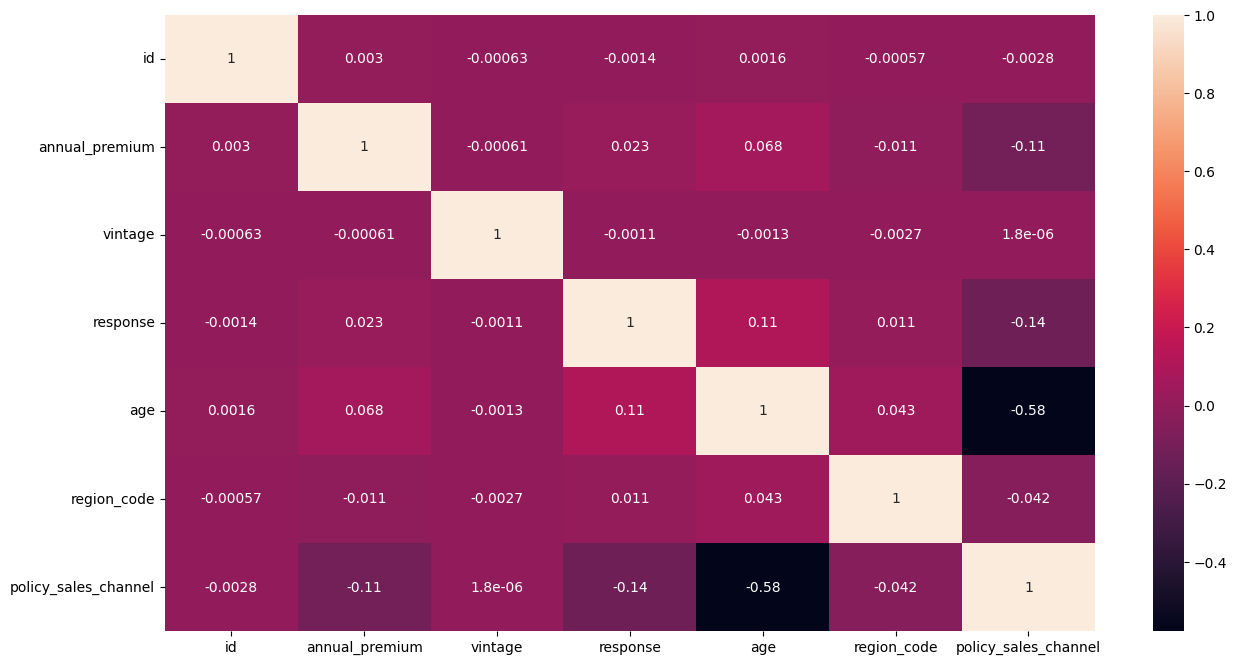

In [79]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

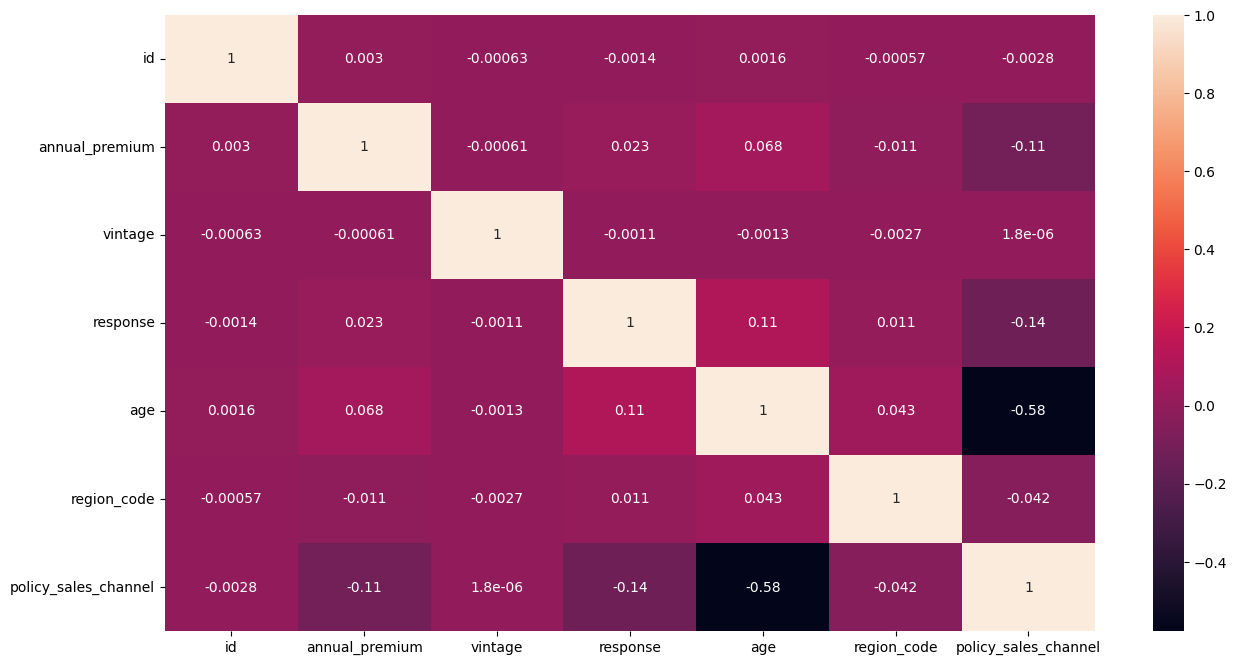

In [80]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### **4.3.2 Categorical attributes**

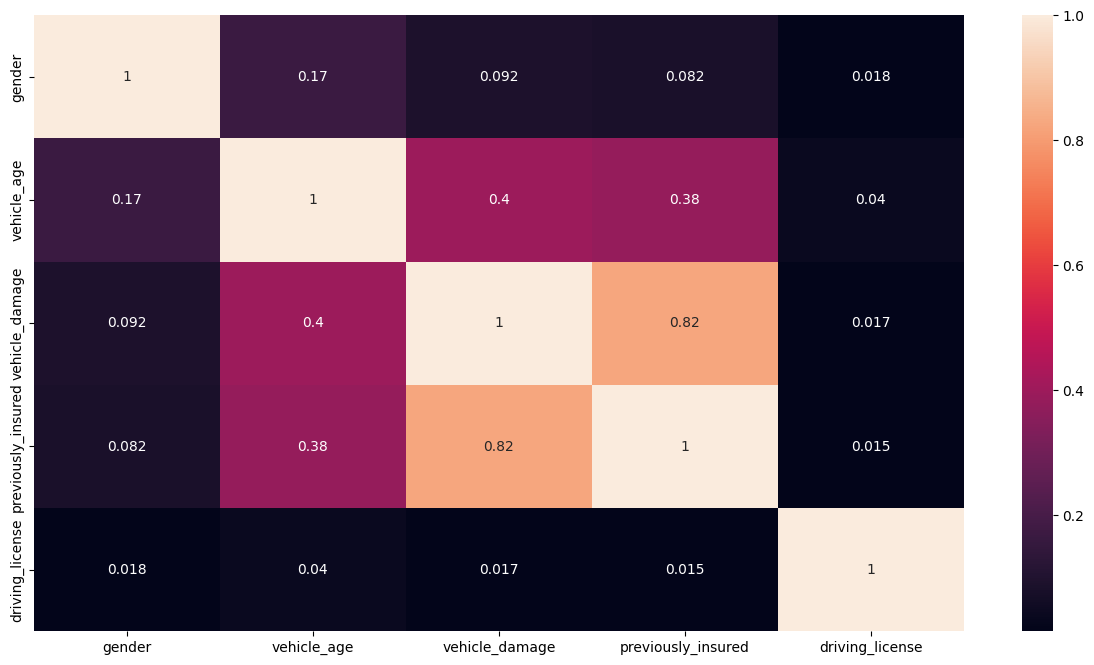

In [81]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )
a3 = cramer_v( a['gender'], a['vehicle_damage'] )
a4 = cramer_v( a['gender'], a['previously_insured'] )
a5 = cramer_v( a['gender'], a['driving_license'] )

a6 = cramer_v( a['vehicle_age'], a['gender'] )
a7 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a8 = cramer_v( a['vehicle_age'], a['vehicle_damage'] )
a9 = cramer_v( a['vehicle_age'], a['previously_insured'] )
a10 = cramer_v( a['vehicle_age'], a['driving_license'] )

a11 = cramer_v( a['vehicle_damage'], a['gender'] )
a12 = cramer_v( a['vehicle_damage'], a['vehicle_age'] )
a13 = cramer_v( a['vehicle_damage'], a['vehicle_damage'] )
a14 = cramer_v( a['vehicle_damage'], a['previously_insured'] )
a15 = cramer_v( a['vehicle_damage'], a['driving_license'] )

a16 = cramer_v( a['previously_insured'], a['gender'] )
a17 = cramer_v( a['previously_insured'], a['vehicle_age'] )
a18 = cramer_v( a['previously_insured'], a['vehicle_damage'] )
a19 = cramer_v( a['previously_insured'], a['previously_insured'] )
a20 = cramer_v( a['previously_insured'], a['driving_license'] )

a21 = cramer_v( a['driving_license'], a['gender'] )
a22 = cramer_v( a['driving_license'], a['vehicle_age'] )
a23 = cramer_v( a['driving_license'], a['vehicle_damage'] )
a24 = cramer_v( a['driving_license'], a['previously_insured'] )
a25 = cramer_v( a['driving_license'], a['driving_license'] )

# Final dataset
d = pd.DataFrame( {'gender':          [a1, a2, a3, a4, a5], 
                   'vehicle_age':     [a6, a7, a8, a9, a10],
                   'vehicle_damage':  [a11, a12, a13, a14, a15],  
                'previously_insured': [a16, a17, a18, a19, a20],
                   'driving_license': [a21, a22, a23, a24, a25]})

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# **Step 5 Data preparation**

In [167]:
df4=pd.read_csv('df4',low_memory=False)
df5=df4.copy()

In [168]:
# encontrar o poder de generalização pq vai usar dados q o modelo nunca viu

X=df5.drop('response',axis=1)
y=df5['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X,y,test_size=0.20,random_state=42)

df5=pd.concat ([x_train, y_train], axis=1) # se torna o dataset de treino

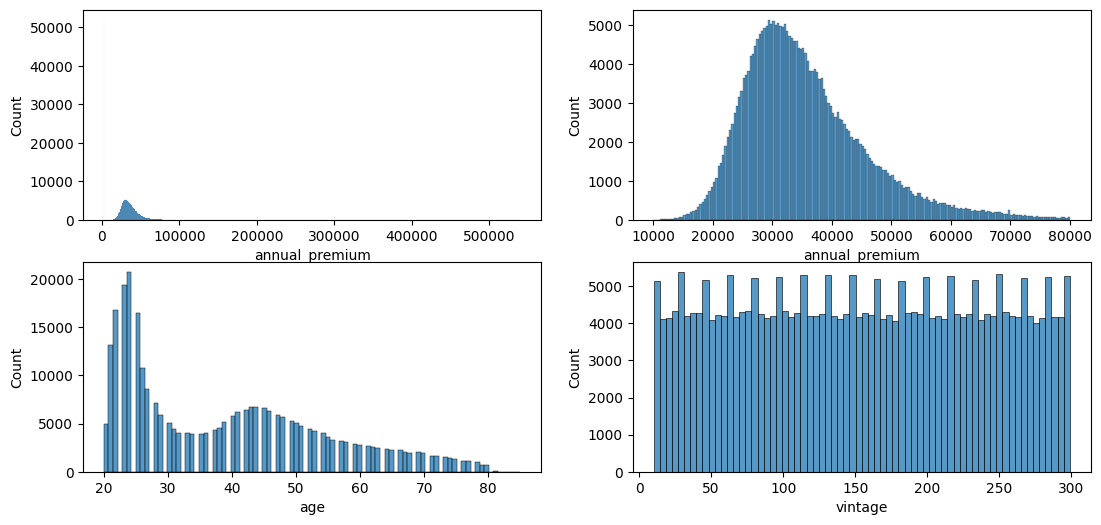

In [169]:
rcParams['figure.figsize'] = 13,6

plt.subplot(2,2,1)
sns.histplot(df5['annual_premium']);

plt.subplot(2,2,2)
aux=df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00=aux.loc[df4['response']==0,'annual_premium']        
sns.histplot(aux00);

plt.subplot(2,2,3)
sns.histplot(df5['age']); # plota a predominância ( 25 mil exemplos [não interessados])
# não é próxima de uma normal, por isso rescaling

plt.subplot(2,2,4)
sns.histplot(df5['vintage']);
# não possue distribuição

## **5.1 Standardization**

In [170]:
# ANNUAL_PREMIUM

ss=pp.StandardScaler()
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values) # duplo colchetes p/ pegar o array -sempre passar como array nos encoders

x_validation['annual_premium']=ss.transform(x_validation[['annual_premium']].values)

## **5.2 Rescaling**

In [171]:
# AGE

mms_age=pp.MinMaxScaler()

df5['age']=mms_age.fit_transform(df5[['age']].values)
x_validation['age']=mms_age.transform(x_validation[['age']].values)

# VINTAGE

mms_vintage=pp.MinMaxScaler()
df5['vintage']=mms_vintage.fit_transform(df5[['vintage']].values)
x_validation['vintage']=mms_vintage.transform(x_validation[['vintage']].values)

## **5.3 Encoder**

In [172]:
# GENDER
# target_encode_gender=df5.groupby('gender')['response'].mean()
# df5.loc[:,'gender']=df5['gender'].map(target_encode_gender)

df5=pd.get_dummies(df5,prefix='gender',columns=['gender'])
x_validation=pd.get_dummies(x_validation,prefix='gender',columns=['gender'])


# REGION_CODE
#  frequency encoding / target encoding / weighted target encoding

target_encode_region_code=df5.groupby('region_code')['response'].mean()
df5['region_code']=df5['region_code'].map(target_encode_region_code)  # mapear a representatividade em termos de frequência
x_validation['region_code']=x_validation['region_code'].map(target_encode_region_code) 


# VEHICLE_AGE
# pode usar order encoding/one hot encoding/frequency encoding, correndo o risco de desconsiderar carros com 2 meses ou 15 meses por exemplo
# get dummies do pandas = one hot encoding, dummies é melhor por já entregar as colunas mapeadas

df5=pd.get_dummies(df5,prefix='vehicle_age',columns=['vehicle_age'])
x_validation=pd.get_dummies(x_validation,prefix='vehicle_age',columns=['vehicle_age'])


# POLICY_SALES_CHANNEL

# target encoding/frequency encoding

fe_policy_sales_channel=df5.groupby('policy_sales_channel').size()/len(df5)  # (quantos exemplos por agrupamento e dividir pelo dataset inteiro p/atribuir o peso dessa variávael
# em relação à base inteira)
df5['policy_sales_channel']=df5['policy_sales_channel'].map(fe_policy_sales_channel)
x_validation['policy_sales_channel']=x_validation['policy_sales_channel'].map(fe_policy_sales_channel)


# PREVIOUSLY_INSURED

df5['previously_insured']=df5['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)
x_validation['previously_insured']=x_validation['previously_insured'].apply(lambda x: 1 if x == 'Yes' else 0)


# DRIVING_LICENSE

df5['driving_license']=df5['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)
x_validation['driving_license']=x_validation['driving_license'].apply(lambda x: 1 if x == 'Yes' else 0)


# VEHICLE_DAMAGE

df5['vehicle_damage']=df5['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
x_validation['vehicle_damage']=x_validation['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

x_validation=x_validation.fillna(0)

# **Step 6 Feature Selection**

In [69]:
df6=df5.copy()

## **6.1 Feature importance**

In [23]:
# model definition
forest=en.ExtraTreesClassifier(n_estimators=250,random_state=0,n_jobs=-1) 

# recebe os dados de treino e a variável resposta
# data preparation
x_train_n=df6.drop(['id','response'],axis=1)
y_train_n=y_train.values
forest.fit(x_train_n,y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking
                         feature  importance
0                        vintage    0.272644
0                 annual_premium    0.244569
0                            age    0.167744
0                    region_code    0.106285
0                 vehicle_damage    0.073512
0           policy_sales_channel    0.061830
0             previously_insured    0.049459
0       vehicle_age_below_1_year    0.012883
0  vehicle_age_between_1_2_years    0.006383
0       vehicle_age_over_2_years    0.002438
0                  gender_Female    0.000888
0                    gender_Male    0.000886
0                driving_license    0.000479


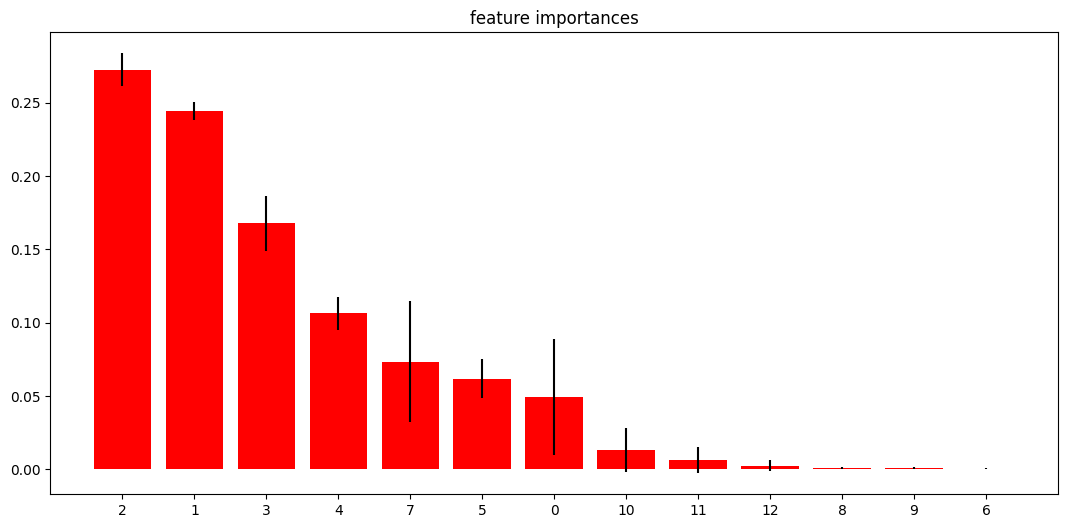

In [24]:
importances=forest.feature_importances_
std=np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices=np.argsort(importances)[::-1]  # índice é a importância das árvores ornada pelo maior valor

# print the feature ranking
print('Feature ranking')
df=pd.DataFrame()
for i, j in zip(x_train_n,forest.feature_importances_): # zip é pra arrumar as colunas com os valores
    aux=pd.DataFrame({'feature':i,'importance':j},index=[0])
    df=pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance',ascending=False))

# plot the imputiry-based feature importances of the forest
plt.figure()
plt.title('feature importances')
plt.bar(range(x_train_n.shape[1]),importances[indices],color='r',yerr=std[indices],align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

# **Step 7 Machine learning**

In [173]:
df7=df5.copy()

In [174]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df7[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation

## **7.1 Logistic regression**

              precision    recall  f1-score   support

           0     0.8751    1.0000    0.9334     66699
           1     0.0000    0.0000    0.0000      9523

    accuracy                         0.8751     76222
   macro avg     0.4375    0.5000    0.4667     76222
weighted avg     0.7657    0.8751    0.8168     76222

Precision at 20% 0.19047619047619047 

Precision at 50% 0.19607843137254902 

Recall at 20% 0.00042003570303475793 

Recall at 50% 0.0010500892575868949 

Top k accuracy_score 76222


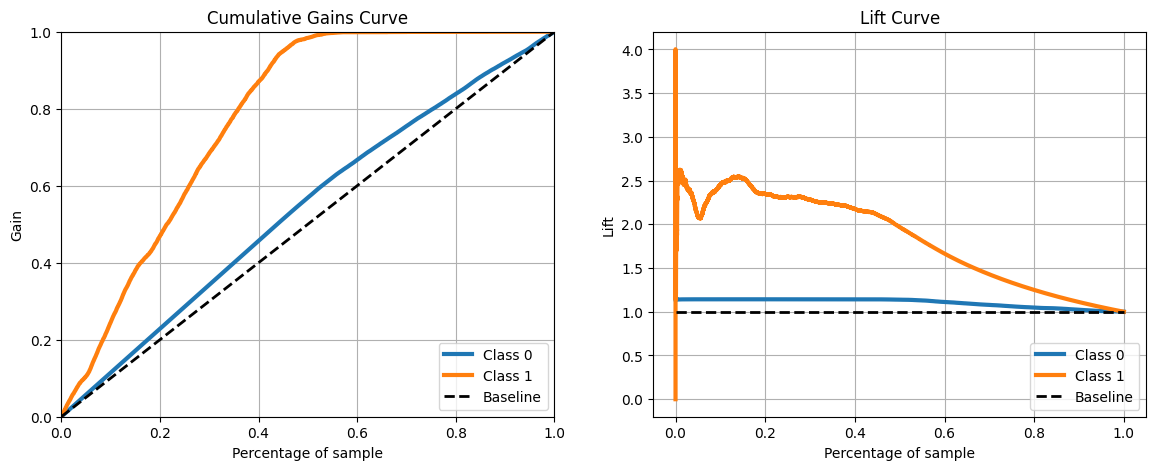

In [175]:
# model definition
lr=lm.LogisticRegression(random_state=42)

# model training
lr.fit(x_train,y_train)

# model prediction
yhat_lr=lr.predict_proba(x_val);

# model prediction 2
yhat_lr2=lr.predict(x_val);
print((classification_report(y_val, yhat_lr2,digits=4)))


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_lr[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=20 )
precision_at_50, data = precision_at_k( df, k=50 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=20 )
recall_at_50, data = recall_at_k( df, k=50 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')
print(f'Top k accuracy_score {top_k_accuracy_score(y_val, yhat_lr2, k=2,normalize=False)}')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lr,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lr,ax=ax2 );

## **7.2 Decision Tree Classifier**

              precision    recall  f1-score   support

           0     0.9003    0.8957    0.8980     66699
           1     0.2948    0.3055    0.3001      9523

    accuracy                         0.8219     76222
   macro avg     0.5976    0.6006    0.5990     76222
weighted avg     0.8247    0.8219    0.8233     76222

Precision at 20% 0.14285714285714285 

Precision at 50% 0.11764705882352941 

Recall at 20% 0.0003150267772760685 

Recall at 50% 0.000630053554552137 

Top k accuracy_score 1.0


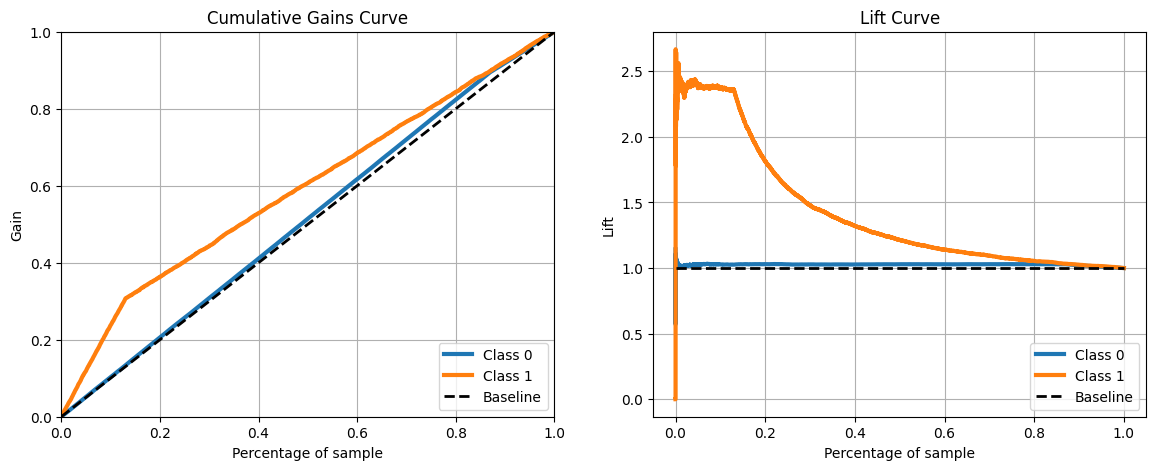

In [176]:
# model definition
dtc = DecisionTreeClassifier(random_state=42)

# model training
dtc.fit(x_train,y_train)

# model prediction
yhat_dtc=dtc.predict_proba(x_val);

# model prediction 2
yhat_dtc2=dtc.predict(x_val);
print((classification_report(y_val, yhat_dtc2,digits=4)))


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_dtc[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=20 )
precision_at_50, data = precision_at_k( df, k=50 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=20 )
recall_at_50, data = recall_at_k( df, k=50 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')
print(f'Top k accuracy_score {top_k_accuracy_score(y_val, yhat_dtc2, k=2)}')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_dtc,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_dtc,ax=ax2 );

## **7.3 Knn**

              precision    recall  f1-score   support

           0     0.8879    0.9509    0.9183     66699
           1     0.3162    0.1591    0.2117      9523

    accuracy                         0.8519     76222
   macro avg     0.6020    0.5550    0.5650     76222
weighted avg     0.8165    0.8519    0.8300     76222

Precision at 20% 0.2857142857142857 

Precision at 50% 0.27450980392156865 

Recall at 20% 0.000630053554552137 

Recall at 50% 0.001470124960621653 

Top k accuracy_score 1.0


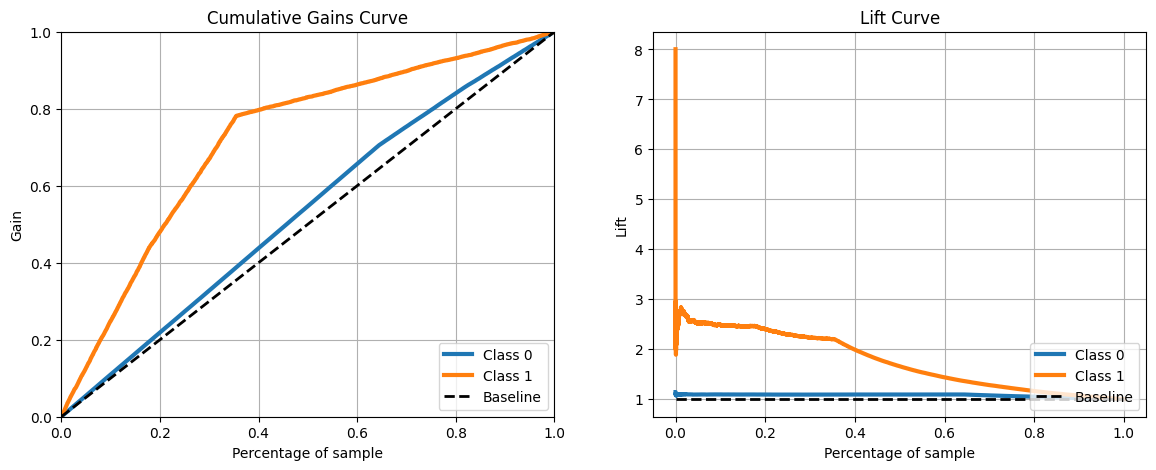

In [177]:
# model definition
knn=nh.KNeighborsClassifier(n_jobs=-1)

# model training
knn.fit(x_train,y_train)

# model prediction
yhat_knn=knn.predict_proba(x_val);

# model prediction 2
yhat_knn2=knn.predict(x_val);
print((classification_report(y_val, yhat_knn2,digits=4)))


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=20 )
precision_at_50, data = precision_at_k( df, k=50 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=20 )
recall_at_50, data = recall_at_k( df, k=50 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')
print(f'Top k accuracy_score {top_k_accuracy_score(y_val, yhat_knn2, k=2)}')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_knn,ax=ax2 );

## **7.4 Extra trees**

              precision    recall  f1-score   support

           0     0.8875    0.9607    0.9227     66699
           1     0.3486    0.1474    0.2072      9523

    accuracy                         0.8591     76222
   macro avg     0.6181    0.5541    0.5649     76222
weighted avg     0.8202    0.8591    0.8333     76222

Precision at 20% 0.09523809523809523 

Precision at 50% 0.29411764705882354 

Recall at 20% 0.00021001785151737897 

Recall at 50% 0.0015751338863803424 

Top k accuracy_score 1.0


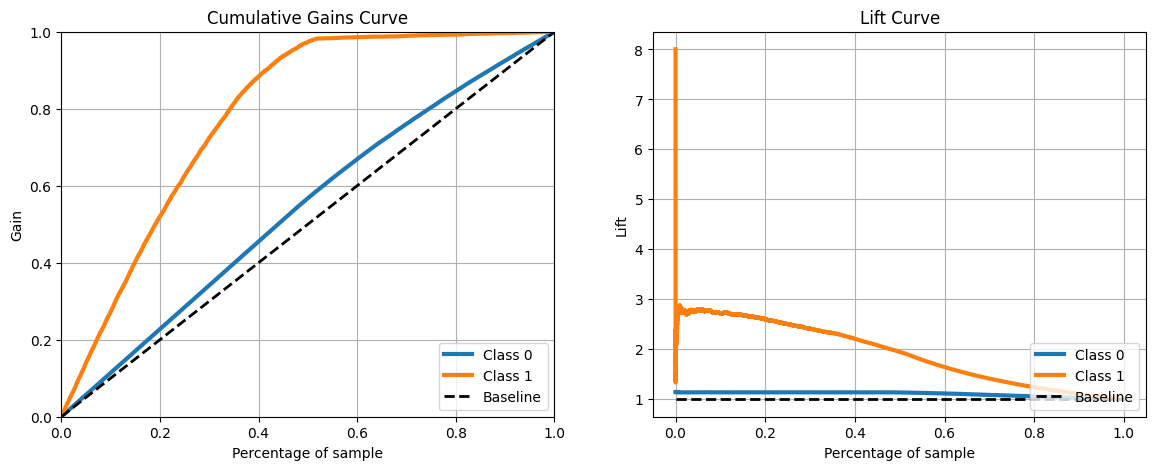

In [178]:
# model definition
et=en.ExtraTreesClassifier(n_jobs=-1,random_state=42)

# model training
et.fit(x_train,y_train)

# model prediction
yhat_et=et.predict_proba(x_val);

# model prediction 2
yhat_et2=et.predict(x_val);
print((classification_report(y_val, yhat_et2,digits=4)))


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=20 )
precision_at_50, data = precision_at_k( df, k=50 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=20 )
recall_at_50, data = recall_at_k( df, k=50 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')
print(f'Top k accuracy_score {top_k_accuracy_score(y_val, yhat_et2, k=2)}')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_et,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_et,ax=ax2 );

## 7.5 Random forest

              precision    recall  f1-score   support

           0     0.8859    0.9699    0.9260     66699
           1     0.3732    0.1255    0.1878      9523

    accuracy                         0.8644     76222
   macro avg     0.6296    0.5477    0.5569     76222
weighted avg     0.8219    0.8644    0.8338     76222

Precision at 20% 0.42857142857142855 

Precision at 50% 0.4117647058823529 

Recall at 20% 0.0009450803318282054 

Recall at 50% 0.0022051874409324793 

Top k accuracy_score 1.0


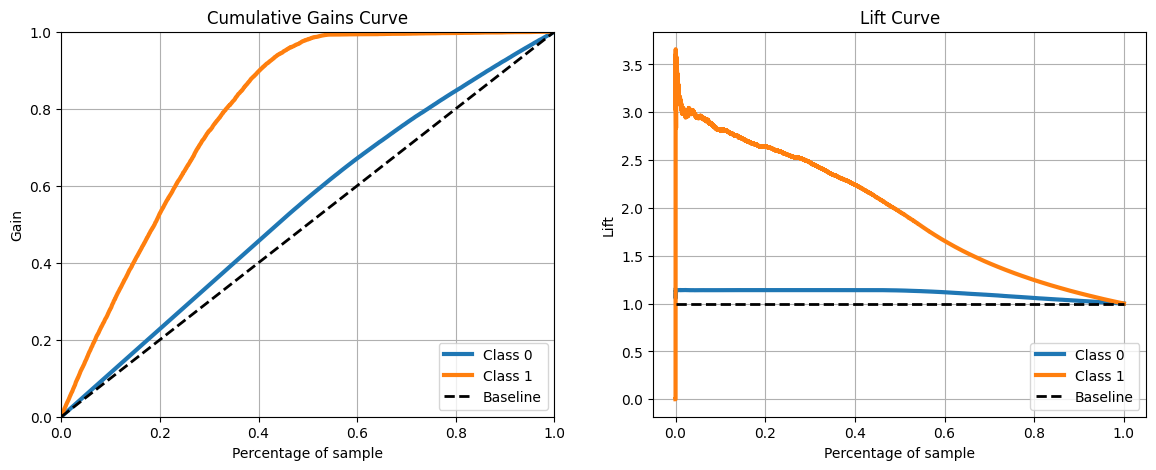

In [179]:
# model definition
rf = en.RandomForestClassifier(n_jobs=-1, random_state=42) 

# model training
rf.fit(x_train,y_train)

# model prediction
yhat_rf=rf.predict_proba(x_val);

# model prediction 2
yhat_rf2=rf.predict(x_val);
print((classification_report(y_val, yhat_rf2,digits=4)))


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_rf[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=20 )
precision_at_50, data = precision_at_k( df, k=50 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=20 )
recall_at_50, data = recall_at_k( df, k=50 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')
print(f'Top k accuracy_score {top_k_accuracy_score(y_val, yhat_rf2, k=2)}')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_rf,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_rf,ax=ax2 );

## **7.6 XGB Classifier**

              precision    recall  f1-score   support

           0     0.8764    0.9977    0.9331     66699
           1     0.4775    0.0145    0.0281      9523

    accuracy                         0.8749     76222
   macro avg     0.6770    0.5061    0.4806     76222
weighted avg     0.8266    0.8749    0.8201     76222

Precision at 20% 0.3333333333333333 

Precision at 50% 0.47058823529411764 

Recall at 20% 0.0007350624803108265 

Recall at 50% 0.002520214218208548 

Top k accuracy_score 1.0


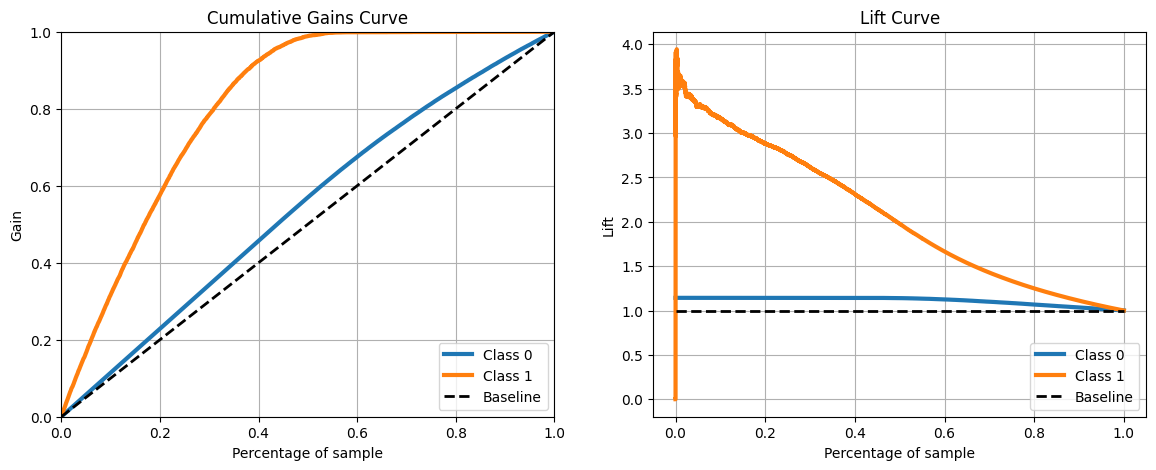

In [180]:
# model definition
xgb_model = xgb.XGBClassifier(n_jobs=-1, random_state=42) 

# model training
xgb_model.fit(x_train,y_train)

# model prediction
yhat_xgb=xgb_model.predict_proba(x_val);

# model prediction 2
yhat_xgb2=xgb_model.predict(x_val);
print((classification_report(y_val, yhat_xgb2,digits=4)))


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_xgb[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=20 )
precision_at_50, data = precision_at_k( df, k=50 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=20 )
recall_at_50, data = recall_at_k( df, k=50 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')
print(f'Top k accuracy_score {top_k_accuracy_score(y_val, yhat_xgb2, k=2)}')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_xgb,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_xgb,ax=ax2 );

## **7.7 LGBM Classifier**

In [191]:
len(x_val)

76222

              precision    recall  f1-score   support

           0     0.8750    0.9996    0.9332     66699
           1     0.0400    0.0001    0.0002      9523

    accuracy                         0.8748     76222
   macro avg     0.4575    0.4999    0.4667     76222
weighted avg     0.7707    0.8748    0.8166     76222

Precision at 20% 0.4362818590704648 

Precision at 50% 0.23529411764705882 

Recall at 20% 0.5785991809303791 

Recall at 50% 0.988133991389268 

Top k accuracy_score 76222


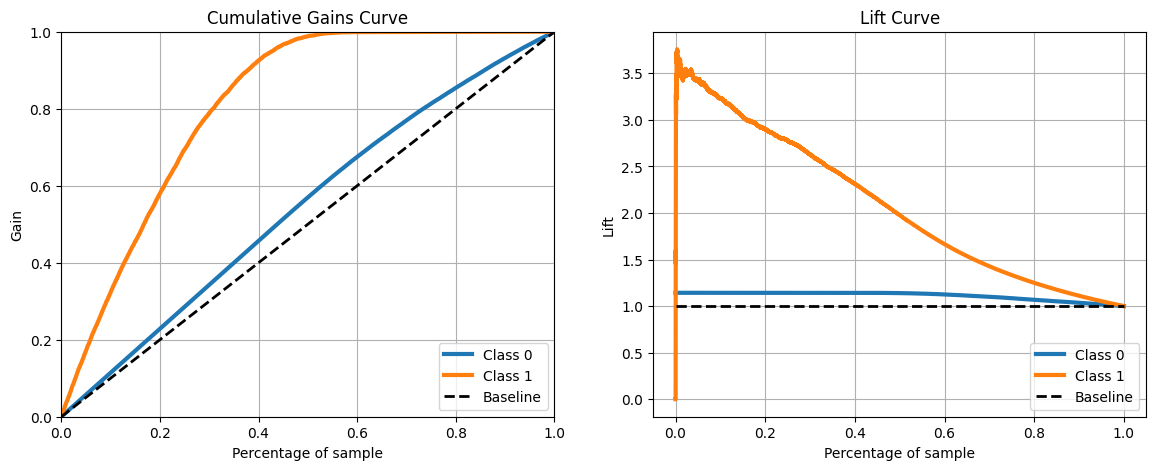

In [194]:
# model definition
lgbm = lightgbm.LGBMClassifier(n_jobs=-1,random_state=42) 

# model training
lgbm.fit(x_train,y_train)

# model prediction
yhat_lgbm=lgbm.predict_proba(x_val);

# model prediction 2
yhat_lgbm2=lgbm.predict(x_val);
print((classification_report(y_val, yhat_lgbm2,digits=4)))


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_lgbm[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_15200, data = precision_at_k( df, k=15200 )
precision_at_38111, data = precision_at_k( df, k=38111 )
print(f'Precision at 20% {precision_at_20000}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_15200, data = recall_at_k( df, k=15200 )
recall_at_38111, data = recall_at_k( df, k=38111 )
print(f'Recall at 20% {recall_at_15200}','\n')
print(f'Recall at 50% {recall_at_38111}','\n')
print(f'Top k accuracy_score {top_k_accuracy_score(y_val, yhat_lgbm2, k=10,normalize=False)}')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lgbm,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm,ax=ax2 );

# **Step 8 Hyperparameter fine tuning + cross validation**

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
              precision    recall  f1-score   support

           0     0.8751    0.9999    0.9334     66699
           1     0.4706    0.0008    0.0017      9523

    accuracy                         0.8750     76222
   macro avg     0.6729    0.5004    0.4675     76222
weighted avg     0.8246    0.8750    0.8170     76222

Precision at 20% 0.5238095238095238 

Precision at 50% 0.47058823529411764 

Recall at 20% 0.0011550981833455844 

Recall at 50% 0.002520214218208548 

Top k accuracy_score 1.0


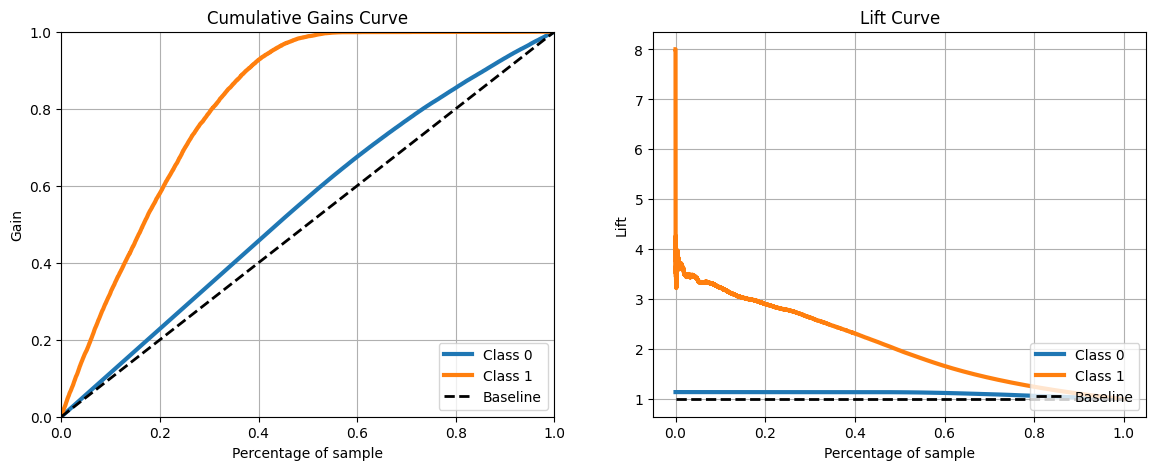

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warnin

In [182]:
#
lgbm = lightgbm.LGBMClassifier(n_jobs=-1,random_state=42, verbose=-1) 


params={'learning_rate': [0.1,0.3],
        'max_depth':[3,12],
        'num_leaves':[40,100],
        'min_data_in_leaf':[50,100]}


lgbm = GridSearchCV(lgbm, param_grid=params,scoring='roc_auc',cv=5,n_jobs=-1,verbose=-1)
lgbm.fit(x_train, y_train)
        

# model prediction
yhat_lgbm=lgbm.predict_proba(x_val);

# model prediction 2
yhat_lgbm2=lgbm.predict(x_val);
print((classification_report(y_val, yhat_lgbm2,digits=4)))


df = x_validation.copy()
df['response'] = y_validation.copy()

# propensity score
df['score'] = yhat_lgbm[:, 1].tolist()

# sort clients by propensity score
df = df.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_20, data = precision_at_k( df, k=20 )
precision_at_50, data = precision_at_k( df, k=50 )
print(f'Precision at 20% {precision_at_20}','\n')
print(f'Precision at 50% {precision_at_50}','\n')

# compute recall at k
recall_at_20, data = recall_at_k( df, k=20 )
recall_at_50, data = recall_at_k( df, k=50 )
print(f'Recall at 20% {recall_at_20}','\n')
print(f'Recall at 50% {recall_at_50}','\n')
print(f'Top k accuracy_score {top_k_accuracy_score(y_val, yhat_lgbm2, k=2)}')

# accumulative gain
rcParams['figure.figsize'] = 14,5
grid=gridspec.GridSpec(1,2)

ax = plt.subplot(grid[0,0]) 
skplt.metrics.plot_cumulative_gain(y_val,yhat_lgbm,ax=ax);

ax2 = plt.subplot(grid[0,1]) 
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm,ax=ax2 );